# **Preprocesamiento de datos para el Análisis de Sentimiento**
### *Implementación De Un Modelo De Recomendación Para Compra o Venta de Acciones En El Mercado Financiero Basado en Análisis De Sentimiento*

[Robert Garcia Rey](https://www.notion.so/Robert-Garcia-Rey-Data-Analyst-6d7b578d2bf848d585dc9d1a97b1036c?pvs=4)
- garcia.robert.0514@eam.edu.co
- https://www.linkedin.com/in/robert-garcia-rey/

## **1. Entendimiento de los datos**

### 1.1 Introducción

El análisis de sentimiento es una técnica analítica que utiliza estadísticas, procesamiento del lenguaje natural (NLP) y aprendizaje automático para determinar la información emocional y subjetiva. En lugar de construir nuestro propio léxico para ello, utilizaremos VADER (Valence Aware Dictionary and sEntiment Reasoner), un modelo de análisis de sentimiento preentrenado incluido en el paquete NLTK. También utilizaremos TextBlob, una sencilla API basada en NLTK, para tareas habituales de NPL.

Así la tarea principal es dejar un dataframe completo para utilizarlo una varios modelos de clasificacón de machine learning para predecir si el precio de cierre del día siguiente de las acciones de Meta,Apple y Microsoft (ya que son de las empresas mas grandes del indice nasdaq), aumentará o disminuirá basándose en el análisis de sentimiento de los artículos de noticias noticias bursátiles de 2019-10-21 al 2023-11-09 recopilados mediante web scraping.

### 1.2 Importamos librerias

In [210]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
import datetime
import re
import nltk
import unicodedata
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from datetime import date, timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.downloader.download('vader_lexicon')
from textblob import TextBlob

from transformers import pipeline

pd.pandas.set_option('display.max_columns', None)

[nltk_data] Downloading package vader_lexicon to C:\Users\Robert
[nltk_data]     G\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 1.3 Importar datos

Leemos los datos de los artículos recopilados por web scraping de Investing.com de los DataFrames de las empresas Meta, Apple y Microsoft.

In [2]:
data_investing_meta = pd.read_pickle('../data/raw/meta_article_investing.pkl') 
print(data_investing_meta.shape),
data_investing_meta.head()

(1502, 5)


ticker publish_date                                              title   
0   META   2023-11-02  Stock Market Today: Dow ends higher as Treasur...  \
1   META   2023-11-02  Wall Street indexes rally on bets of peak US i...   
2   META   2023-11-03  Moderna downside has played out, HSBC raises r...   
3   META   2023-11-03  Uber notches upgrade ahead of Q3 earnings: 4 b...   
4   META   2023-11-08  Moderna Highlights its Digital and AI Strategy...   

                                           body_text   
0  Published Nov 01, 2023 07:08PM ET Updated Nov ...  \
1  Published Nov 02, 2023 05:51AM ET Updated Nov ...   
2  Published Nov 03, 2023 09:49AM ET\n\n© Reuters...   
3  Published Nov 03, 2023 06:10AM ET\n\n© Reuters...   
4  Published Nov 08, 2023 07:04AM ET\n\n© Reuters...   

                                                 url  
0  https://www.investing.com/news/stock-market-ne...  
1  https://www.investing.com/news/economy/futures...  
2  https://www.investing.com/news/stock-market-ne...  
3  https://www.investing.com/news/stock-market-ne...  
4  https://www.investing.com/news/assorted/modern...

In [3]:
data_investing_meta['publish_date'].min(), data_investing_meta['publish_date'].max()

('2021-10-01', '2023-11-09')

In [4]:
data_investing_apple = pd.read_pickle('../data/raw/apple_article_investing.pkl')
print(data_investing_apple.shape),
data_investing_apple.head()

(1427, 5)


ticker publish_date                                              title   
0   AAPL   2023-11-17  Apple and Amazon shares surge amid tech market...  \
1   AAPL   2023-11-17  Analysis-US consumer watchdog hands Wall Stree...   
2   AAPL   2023-11-17  Gap's holiday season outlook, Alibaba slips in...   
3   AAPL   2023-11-17  Apple to support RCS messaging, boosting Andro...   
4   AAPL   2023-11-17  Apple's stock performance stalls as tech rival...   

                                           body_text   
0  Published Nov 17, 2023 09:29AM ET\n\n© Reuters...  \
1  Published Nov 17, 2023 06:02AM ET Updated Nov ...   
2  Published Nov 17, 2023 04:43AM ET\n\n© Reuters...   
3  Published Nov 16, 2023 10:27PM ET Updated Nov ...   
4  Published Nov 17, 2023 03:51AM ET\n\n© Reuters...   

                                                 url  
0  https://www.investing.com/news/stock-market-ne...  
1  https://www.investing.com/news/stock-market-ne...  
2  https://www.investing.com/news/economy/gaps-ho...  
3  https://www.investing.com/news/stock-market-ne...  
4  https://www.investing.com/news/stock-market-ne...

In [5]:
data_investing_apple['publish_date'].min(), data_investing_apple['publish_date'].max()

('2023-07-07', '2023-11-17')

In [6]:
data_investing_msft = pd.read_pickle('../data/raw/msft_article_investing.pkl')
print(data_investing_msft.shape),
data_investing_msft.head()

(1458, 5)


ticker publish_date                                              title   
0   MSFT   2023-11-17  Wedbush expects 'short covering for the ages,'...  \
1   MSFT   2023-11-17  OpenAI announces CEO Sam Altman to depart the ...   
2   MSFT   2023-11-18  Ousted OpenAI CEO Altman welcome in France, mi...   
3   MSFT   2023-11-18  In ousting CEO Sam Altman, ChatGPT loses its b...   
4   MSFT   2023-11-17  FBI warns on Scattered Spider hackers, urges v...   

                                           body_text   
0  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  \
1  Published Nov 17, 2023 03:36PM ET\n\n© Reuters...   
2  Published Nov 18, 2023 09:04AM ET\n\n2/2 © Reu...   
3  Published Nov 17, 2023 08:29PM ET\n\n© Reuters...   
4  Published Nov 16, 2023 03:37PM ET Updated Nov ...   

                                                 url  
0  https://www.investing.com/news/stock-market-ne...  
1  https://www.investing.com/news/assorted/openai...  
2  https://www.investing.com/news/stock-market-ne...  
3  https://www.investing.com/news/stock-market-ne...  
4  https://www.investing.com/news/stock-market-ne...

In [7]:
data_investing_msft['publish_date'].min(), data_investing_msft['publish_date'].max()

('2023-06-21', '2023-11-18')

Ahora leemos los datos de los precios de las acciones las empresas Meta, Apple y Microsoft.

In [8]:
data_yfinance_meta = pd.read_pickle('../data/raw/meta_price_yfinance.pkl') 
data_yfinance_meta = round(data_yfinance_meta, 2)
print(data_yfinance_meta.shape),
data_yfinance_meta.head()

(530, 6)


Open    High     Low   Close  Adj Close    Volume
Date                                                           
2021-10-01  341.61  345.02  338.64  343.01     343.01  14905300
2021-10-04  335.53  335.94  322.70  326.23     326.23  42885000
2021-10-05  328.58  335.18  326.16  332.96     332.96  35377900
2021-10-06  329.74  334.38  325.80  333.64     333.64  26443000
2021-10-07  337.00  338.84  328.98  329.22     329.22  28307500

In [9]:
data_yfinance_meta.index.min(), data_yfinance_meta.index.max()

(Timestamp('2021-10-01 00:00:00'), Timestamp('2023-11-08 00:00:00'))

In [10]:
data_yfinance_apple = pd.read_pickle('../data/raw/apple_price_yfinance.pkl')
data_yfinance_apple = round(data_yfinance_apple, 2)
print(data_yfinance_apple.shape),
data_yfinance_apple.head()

(94, 6)


Open    High     Low   Close  Adj Close    Volume
Date                                                           
2023-07-07  191.41  192.67  190.24  190.68     190.17  46778000
2023-07-10  189.26  189.99  187.04  188.61     188.11  59922200
2023-07-11  189.16  189.30  186.60  188.08     187.58  46638100
2023-07-12  189.68  191.70  188.47  189.77     189.26  60750200
2023-07-13  190.50  191.19  189.78  190.54     190.03  41342300

In [11]:
data_yfinance_apple.index.min(), data_yfinance_apple.index.max()

(Timestamp('2023-07-07 00:00:00'), Timestamp('2023-11-16 00:00:00'))

In [12]:
data_yfinance_msft = pd.read_pickle('../data/raw/msft_price_yfinance.pkl')
data_yfinance_msft = round(data_yfinance_msft, 2)
print(data_yfinance_msft.shape),
data_yfinance_msft.head()

(106, 6)


Open    High     Low   Close  Adj Close    Volume
Date                                                           
2023-06-21  336.37  337.73  332.07  333.56     332.18  25117800
2023-06-22  334.12  340.12  333.34  339.71     338.31  23556800
2023-06-23  334.36  337.96  333.45  335.02     333.64  23084700
2023-06-26  333.72  336.11  328.49  328.60     327.24  21520600
2023-06-27  331.86  336.15  329.30  334.57     333.19  24354100

In [13]:
data_yfinance_msft.index.min(), data_yfinance_msft.index.max()

(Timestamp('2023-06-21 00:00:00'), Timestamp('2023-11-17 00:00:00'))

### 1.4 Información del datasets de noticias cargados

In [14]:
data_investing_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ticker        1502 non-null   object
 1   publish_date  1502 non-null   object
 2   title         1502 non-null   object
 3   body_text     1502 non-null   object
 4   url           1502 non-null   object
dtypes: object(5)
memory usage: 58.8+ KB


In [15]:
data_investing_apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ticker        1427 non-null   object
 1   publish_date  1427 non-null   object
 2   title         1427 non-null   object
 3   body_text     1427 non-null   object
 4   url           1427 non-null   object
dtypes: object(5)
memory usage: 55.9+ KB


In [16]:
data_investing_msft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ticker        1458 non-null   object
 1   publish_date  1458 non-null   object
 2   title         1458 non-null   object
 3   body_text     1458 non-null   object
 4   url           1458 non-null   object
dtypes: object(5)
memory usage: 57.1+ KB


In [17]:
data_yfinance_meta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 530 entries, 2021-10-01 to 2023-11-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       530 non-null    float64
 1   High       530 non-null    float64
 2   Low        530 non-null    float64
 3   Close      530 non-null    float64
 4   Adj Close  530 non-null    float64
 5   Volume     530 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 29.0 KB


In [18]:
data_yfinance_apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94 entries, 2023-07-07 to 2023-11-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       94 non-null     float64
 1   High       94 non-null     float64
 2   Low        94 non-null     float64
 3   Close      94 non-null     float64
 4   Adj Close  94 non-null     float64
 5   Volume     94 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 5.1 KB


In [19]:
data_yfinance_msft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2023-06-21 to 2023-11-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       106 non-null    float64
 1   High       106 non-null    float64
 2   Low        106 non-null    float64
 3   Close      106 non-null    float64
 4   Adj Close  106 non-null    float64
 5   Volume     106 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 5.8 KB


### 1.5 Ajustando los tipos de datos

Convertimos la variable publish_date a tipo de fecha en los 3 DataFrame

In [20]:
# Convertir la columna 'publish_date' a tipo fecha
data_investing_meta['publish_date'] = pd.to_datetime(data_investing_meta['publish_date'])

data_investing_apple['publish_date'] = pd.to_datetime(data_investing_apple['publish_date'])

data_investing_msft['publish_date'] = pd.to_datetime(data_investing_msft['publish_date'])

Convertimos las variables Objet a tipo de Category en los 3 DataFrame

In [21]:
# Para las variables "object" las convertimos a "category"
data_investing_meta = data_investing_meta.apply(lambda col: col.astype('category') if col.dtype == 'O' else col)

data_investing_apple = data_investing_apple.apply(lambda col: col.astype('category') if col.dtype == 'O' else col)

data_investing_msft = data_investing_msft.apply(lambda col: col.astype('category') if col.dtype == 'O' else col)

Verificamos los nuevos tipos de datos

In [22]:
data_investing_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ticker        1502 non-null   category      
 1   publish_date  1502 non-null   datetime64[ns]
 2   title         1502 non-null   category      
 3   body_text     1502 non-null   category      
 4   url           1502 non-null   category      
dtypes: category(4), datetime64[ns](1)
memory usage: 144.9 KB


In [23]:
data_investing_apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ticker        1427 non-null   category      
 1   publish_date  1427 non-null   datetime64[ns]
 2   title         1427 non-null   category      
 3   body_text     1427 non-null   category      
 4   url           1427 non-null   category      
dtypes: category(4), datetime64[ns](1)
memory usage: 142.5 KB


In [24]:
data_investing_msft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ticker        1458 non-null   category      
 1   publish_date  1458 non-null   datetime64[ns]
 2   title         1458 non-null   category      
 3   body_text     1458 non-null   category      
 4   url           1458 non-null   category      
dtypes: category(4), datetime64[ns](1)
memory usage: 142.7 KB


## **2. Preparación de datos**

### **Primero que todo hacemos un analisis exploratorio inicial de los datos**

Cantidad de noticias obtenidas en total por cada mes, para los emisores de acciones

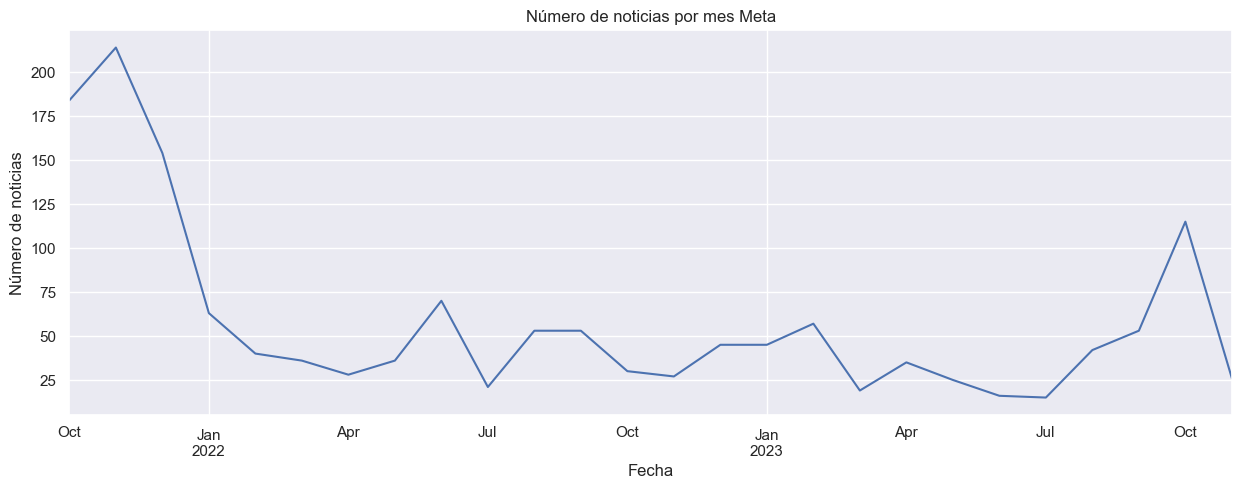

In [236]:
# Configurar la fuente de texto
plt.rcParams['font.family'] = 'Arial'  # Puedes reemplazar 'Arial' con una fuente disponible en tu sistema

# Luego, crea tu gráfico
data_investing_meta['publish_date'].groupby(data_investing_meta['publish_date'].dt.to_period('M')).agg('count').plot(
    kind='line', figsize=(15, 5), title='Número de noticias por mes Meta', ylabel='Número de noticias', xlabel='Fecha'
)
plt.show()

In [230]:
data_investing_meta['publish_date'].count()

1502

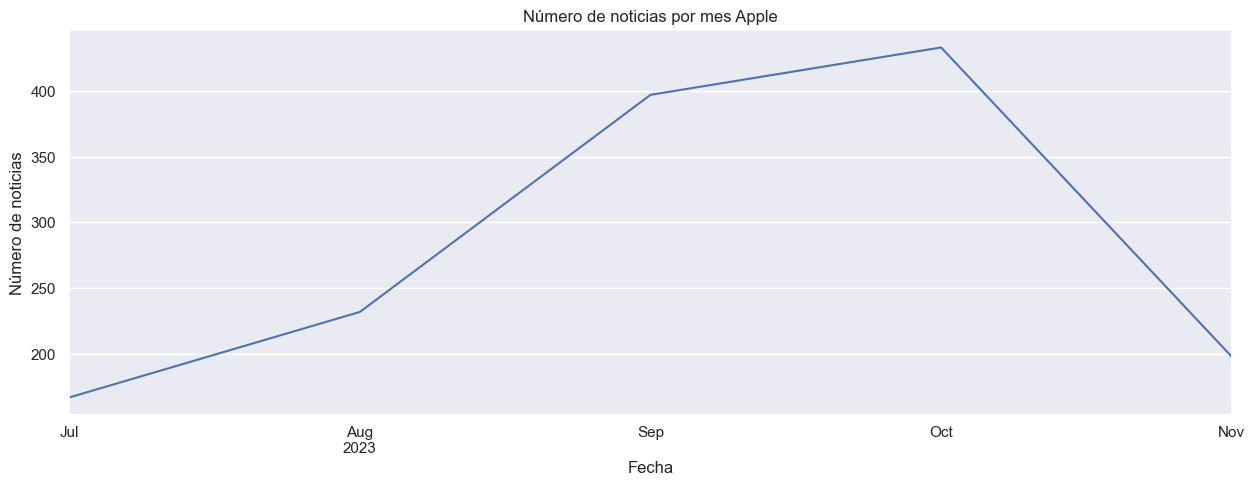

In [235]:
# Configurar la fuente de texto
plt.rcParams['font.family'] = 'Arial'  # Puedes reemplazar 'Arial' con una fuente disponible en tu sistema

# Luego, crea tu gráfico
data_investing_apple['publish_date'].groupby(data_investing_apple['publish_date'].dt.to_period('M')).agg('count').plot(
    kind='line', figsize=(15, 5), title='Número de noticias por mes Apple', ylabel='Número de noticias', xlabel='Fecha'
)
plt.show()

In [232]:
data_investing_apple['publish_date'].count()

1427

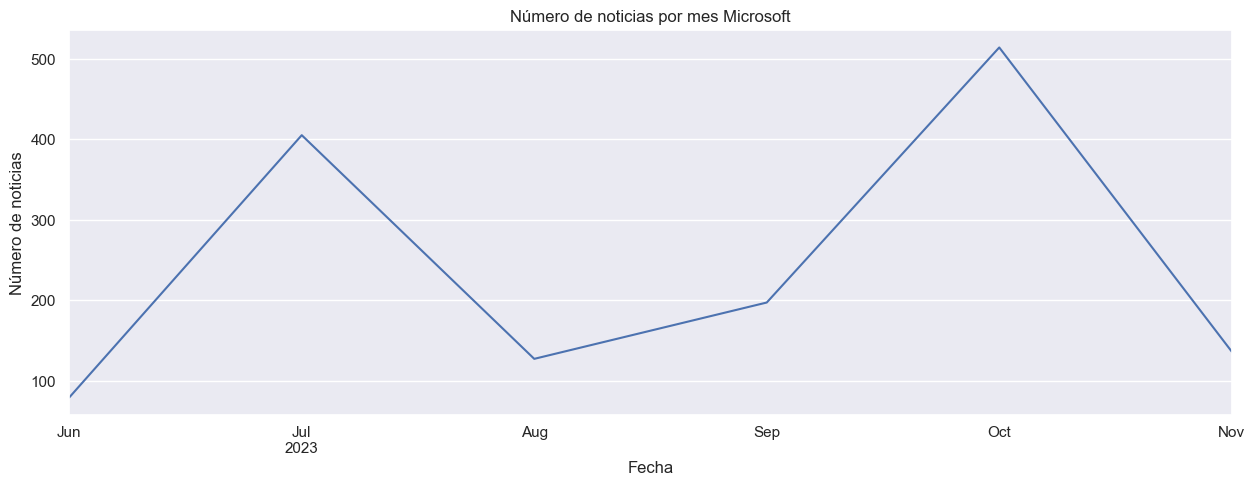

In [234]:
# Configurar la fuente de texto
plt.rcParams['font.family'] = 'Arial'  # Puedes reemplazar 'Arial' con una fuente disponible en tu sistema

# Luego, crea tu gráfico
data_investing_msft['publish_date'].groupby(data_investing_msft['publish_date'].dt.to_period('M')).agg('count').plot(
    kind='line', figsize=(15, 5), title='Número de noticias por mes Microsoft', ylabel='Número de noticias', xlabel='Fecha'
)

plt.show()

In [237]:
data_investing_msft['publish_date'].count()

1458

In [238]:
data_investing_msft['publish_date'].count() + data_investing_apple['publish_date'].count() + data_investing_meta['publish_date'].count()

4387

### **Volumen y precios diario de negociación**

In [245]:
round(data_yfinance_meta.describe(), 2)

Open    High     Low  Adj Close        Volume
count  530.00  530.00  530.00     530.00  5.300000e+02
mean   226.40  230.18  222.99     226.50  2.996930e+07
std     74.58   75.13   73.69      74.37  1.963238e+07
min     90.08   90.46   88.09      88.91  8.629300e+06
25%    167.01  169.72  162.17     167.14  1.943285e+07
50%    212.12  215.42  208.76     212.84  2.533985e+07
75%    301.64  306.87  298.69     301.66  3.419515e+07
max    349.05  353.83  345.20     347.56  2.323166e+08

In [249]:
round(data_yfinance_meta['Volume'].mean(),0)

29969302.0

In [247]:
round(data_yfinance_apple.describe(), 2)

Open    High     Low  Adj Close        Volume
count   94.00   94.00   94.00      94.00  9.400000e+01
mean   180.90  182.48  179.44     180.68  5.781830e+07
std      7.90    7.69    7.91       7.59  1.522463e+07
min    166.91  168.96  165.67     166.67  3.517510e+07
25%    175.10  177.00  173.76     175.24  4.749170e+07
50%    178.70  179.99  177.22     178.43  5.472565e+07
75%    188.17  189.26  186.93     187.61  6.120495e+07
max    196.24  198.23  195.28     195.93  1.157997e+08

In [250]:
round(data_yfinance_apple['Volume'].mean(),0)

57818302.0

In [251]:
round(data_yfinance_msft.describe(), 2)

Open    High     Low  Adj Close       Volume
count  106.00  106.00  106.00     106.00       106.00
mean   334.55  337.68  331.32     333.50  24838143.40
std     13.72   13.89   13.59      13.99   9462845.23
min    310.99  314.30  309.45     311.51  12508700.00
25%    326.00  329.25  322.16     325.48  19568475.00
50%    332.26  335.85  328.88     330.57  22600700.00
75%    339.29  341.76  336.34     337.86  26750400.00
max    373.61  376.35  370.18     376.17  69368900.00

In [252]:
round(data_yfinance_msft['Volume'].mean(),0)

24838143.0

### 2.1 Eliminación de variables
- Eliminar variables irrelevantes para la minería
- Eliminar variables redundantes

Eliminamos las variables 'ticker' y 'url' para los 3 DataFrame de noticias

In [25]:
# Variables irrelevantes, ya que no aportan informacion al modelo
var_irrelevantes = ['ticker', 'url']

data_investing_meta = data_investing_meta.drop(columns=var_irrelevantes)

data_investing_meta.head()

publish_date                                              title   
0   2023-11-02  Stock Market Today: Dow ends higher as Treasur...  \
1   2023-11-02  Wall Street indexes rally on bets of peak US i...   
2   2023-11-03  Moderna downside has played out, HSBC raises r...   
3   2023-11-03  Uber notches upgrade ahead of Q3 earnings: 4 b...   
4   2023-11-08  Moderna Highlights its Digital and AI Strategy...   

                                           body_text  
0  Published Nov 01, 2023 07:08PM ET Updated Nov ...  
1  Published Nov 02, 2023 05:51AM ET Updated Nov ...  
2  Published Nov 03, 2023 09:49AM ET\n\n© Reuters...  
3  Published Nov 03, 2023 06:10AM ET\n\n© Reuters...  
4  Published Nov 08, 2023 07:04AM ET\n\n© Reuters...

In [26]:
var_irrelevantes2 = ['ticker', 'url']

data_investing_apple = data_investing_apple.drop(columns=var_irrelevantes2)

data_investing_apple.head()

publish_date                                              title   
0   2023-11-17  Apple and Amazon shares surge amid tech market...  \
1   2023-11-17  Analysis-US consumer watchdog hands Wall Stree...   
2   2023-11-17  Gap's holiday season outlook, Alibaba slips in...   
3   2023-11-17  Apple to support RCS messaging, boosting Andro...   
4   2023-11-17  Apple's stock performance stalls as tech rival...   

                                           body_text  
0  Published Nov 17, 2023 09:29AM ET\n\n© Reuters...  
1  Published Nov 17, 2023 06:02AM ET Updated Nov ...  
2  Published Nov 17, 2023 04:43AM ET\n\n© Reuters...  
3  Published Nov 16, 2023 10:27PM ET Updated Nov ...  
4  Published Nov 17, 2023 03:51AM ET\n\n© Reuters...

In [27]:
var_irrelevantes3 = ['ticker', 'url']

data_investing_msft = data_investing_msft.drop(columns=var_irrelevantes3)

data_investing_msft.head()

publish_date                                              title   
0   2023-11-17  Wedbush expects 'short covering for the ages,'...  \
1   2023-11-17  OpenAI announces CEO Sam Altman to depart the ...   
2   2023-11-18  Ousted OpenAI CEO Altman welcome in France, mi...   
3   2023-11-18  In ousting CEO Sam Altman, ChatGPT loses its b...   
4   2023-11-17  FBI warns on Scattered Spider hackers, urges v...   

                                           body_text  
0  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  
1  Published Nov 17, 2023 03:36PM ET\n\n© Reuters...  
2  Published Nov 18, 2023 09:04AM ET\n\n2/2 © Reu...  
3  Published Nov 17, 2023 08:29PM ET\n\n© Reuters...  
4  Published Nov 16, 2023 03:37PM ET Updated Nov ...

Eliminamos la variable close para los 3 DataFrame de precios

In [28]:
# Variables irrelevantes, ya que no aportan informacion al modelo ni al unir los datasets
var_irrelevantes4 = ['Close']

data_yfinance_meta = data_yfinance_meta.drop(columns=var_irrelevantes4)

data_yfinance_meta.head()

Open    High     Low  Adj Close    Volume
Date                                                   
2021-10-01  341.61  345.02  338.64     343.01  14905300
2021-10-04  335.53  335.94  322.70     326.23  42885000
2021-10-05  328.58  335.18  326.16     332.96  35377900
2021-10-06  329.74  334.38  325.80     333.64  26443000
2021-10-07  337.00  338.84  328.98     329.22  28307500

In [29]:
var_irrelevantes5 = ['Close']

data_yfinance_apple = data_yfinance_apple.drop(columns=var_irrelevantes5)

data_yfinance_apple.head()

Open    High     Low  Adj Close    Volume
Date                                                   
2023-07-07  191.41  192.67  190.24     190.17  46778000
2023-07-10  189.26  189.99  187.04     188.11  59922200
2023-07-11  189.16  189.30  186.60     187.58  46638100
2023-07-12  189.68  191.70  188.47     189.26  60750200
2023-07-13  190.50  191.19  189.78     190.03  41342300

In [30]:
var_irrelevantes6 = ['Close']

data_yfinance_msft = data_yfinance_msft.drop(columns=var_irrelevantes6)

data_yfinance_msft.head()

Open    High     Low  Adj Close    Volume
Date                                                   
2023-06-21  336.37  337.73  332.07     332.18  25117800
2023-06-22  334.12  340.12  333.34     338.31  23556800
2023-06-23  334.36  337.96  333.45     333.64  23084700
2023-06-26  333.72  336.11  328.49     327.24  21520600
2023-06-27  331.86  336.15  329.30     333.19  24354100

### 2.2 Tratamiento de datos nulos
Averiguamos si la variable publish_date de los conjuntos de datos de noticias contiene datos faltantes en terminos de porcentaje

In [31]:
data_investing_meta['publish_date'].isnull().sum() / len(data_investing_meta['publish_date']) * 100

0.0

In [32]:
data_investing_apple['publish_date'].isnull().sum() / len(data_investing_apple['publish_date']) * 100

0.0

In [33]:
data_investing_msft['publish_date'].isnull().sum() / len(data_investing_msft['publish_date']) * 100

0.0

se puede observar que no hay ningun articulo con fecha faltante en los DataFrame de noticias

### 2.3 Tratamiento de datos duplicados

In [34]:
# Creamos una copia de los DataFrames

data_investing_meta_new = data_investing_meta.copy()
data_investing_apple_new = data_investing_apple.copy()
data_investing_msft_new = data_investing_msft.copy()

In [35]:
#Eliminar filas con títulos duplicados
data_investing_meta_new.drop_duplicates(subset ="title", 
                     keep = 'first', inplace = True)

data_investing_meta_new

publish_date                                              title   
0      2023-11-02  Stock Market Today: Dow ends higher as Treasur...  \
1      2023-11-02  Wall Street indexes rally on bets of peak US i...   
2      2023-11-03  Moderna downside has played out, HSBC raises r...   
3      2023-11-03  Uber notches upgrade ahead of Q3 earnings: 4 b...   
4      2023-11-08  Moderna Highlights its Digital and AI Strategy...   
...           ...                                                ...   
1489   2021-10-04  Moderna Stock: Incredible Growth at Uncomforta...   
1490   2021-10-04  Amid COVID-19 booster data dilemma, EU nations...   
1492   2021-10-04  EU regulator backs mRNA vaccine booster for pe...   
1494   2021-10-03  Weekly Review and Calendar Ahead By Investing.com   
1497   2021-10-04  Sweden to give 12-15 year olds Pfizer vaccine,...   

                                              body_text  
0     Published Nov 01, 2023 07:08PM ET Updated Nov ...  
1     Published Nov 02, 2023 05:51AM ET Updated Nov ...  
2     Published Nov 03, 2023 09:49AM ET\n\n© Reuters...  
3     Published Nov 03, 2023 06:10AM ET\n\n© Reuters...  
4     Published Nov 08, 2023 07:04AM ET\n\n© Reuters...  
...                                                 ...  
1489  Published Oct 04, 2021 10:23AM ET Updated Oct ...  
1490  Published Oct 03, 2021 08:14PM ET\n\n© Reuters...  
1492  Published Oct 04, 2021 10:19AM ET Updated Oct ...  
1494  Published Oct 03, 2021 04:24AM ET\n\n© Reuters...  
1497  Published Oct 04, 2021 10:45AM ET Updated Oct ...  

[893 rows x 3 columns]

In [36]:
data_investing_apple_new.drop_duplicates(subset ="title",
                        keep = 'first', inplace = True)
data_investing_apple_new

publish_date                                              title   
0      2023-11-17  Apple and Amazon shares surge amid tech market...  \
1      2023-11-17  Analysis-US consumer watchdog hands Wall Stree...   
2      2023-11-17  Gap's holiday season outlook, Alibaba slips in...   
3      2023-11-17  Apple to support RCS messaging, boosting Andro...   
4      2023-11-17  Apple's stock performance stalls as tech rival...   
...           ...                                                ...   
1421   2023-07-10  Rivian options buyers may be helping drive sto...   
1423   2023-07-10  EU seals new US data transfer pact, but challe...   
1424   2023-07-07  Why a Bitcoin ETF approval would be a big deal...   
1425   2023-07-10  Market heavyweights dip ahead of Nasdaq 100 re...   
1426   2023-07-10  Dow Jones, Nasdaq, S&P 500 weekly preview: Q2 ...   

                                              body_text  
0     Published Nov 17, 2023 09:29AM ET\n\n© Reuters...  
1     Published Nov 17, 2023 06:02AM ET Updated Nov ...  
2     Published Nov 17, 2023 04:43AM ET\n\n© Reuters...  
3     Published Nov 16, 2023 10:27PM ET Updated Nov ...  
4     Published Nov 17, 2023 03:51AM ET\n\n© Reuters...  
...                                                 ...  
1421  Published Jul 10, 2023 04:53PM ET\n\n© Reuters...  
1423  Published Jul 10, 2023 09:58AM ET Updated Jul ...  
1424  Published Jul 07, 2023 08:00AM ET Updated Jul ...  
1425  Published Jul 10, 2023 06:12PM ET\n\n© Reuters...  
1426  Published Jul 10, 2023 09:18AM ET\n\n© Reuters...  

[845 rows x 3 columns]

In [37]:
data_investing_msft_new.drop_duplicates(subset ="title",    
                        keep = 'first', inplace = True)
data_investing_msft_new

publish_date                                              title   
0      2023-11-17  Wedbush expects 'short covering for the ages,'...  \
1      2023-11-17  OpenAI announces CEO Sam Altman to depart the ...   
2      2023-11-18  Ousted OpenAI CEO Altman welcome in France, mi...   
3      2023-11-18  In ousting CEO Sam Altman, ChatGPT loses its b...   
4      2023-11-17  FBI warns on Scattered Spider hackers, urges v...   
...           ...                                                ...   
1445   2023-06-22  Applied Optoelectronics soars 15% on multi-yea...   
1446   2023-06-21  US needs 'comprehensive legislation' to addres...   
1447   2023-06-21  Wall Street extends sell-off as Powell hints a...   
1449   2023-06-21  Short Bets on US Stocks Hit $1 Trillion, Most ...   
1453   2023-06-21  Accenture and Microsoft Expand Collaboration t...   

                                              body_text  
0     Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  
1     Published Nov 17, 2023 03:36PM ET\n\n© Reuters...  
2     Published Nov 18, 2023 09:04AM ET\n\n2/2 © Reu...  
3     Published Nov 17, 2023 08:29PM ET\n\n© Reuters...  
4     Published Nov 16, 2023 03:37PM ET Updated Nov ...  
...                                                 ...  
1445  Published Jun 22, 2023 05:38AM ET\n\n© Reuters...  
1446  Published Jun 21, 2023 06:07AM ET Updated Jun ...  
1447  Published Jun 21, 2023 07:09AM ET Updated Jun ...  
1449  Published Jun 21, 2023 02:24PM ET\n\nUS500 +0....  
1453  Published Jun 21, 2023 03:00PM ET\n\n© Reuters...  

[811 rows x 3 columns]

### 2.4 Combinar todos los dataframe

In [38]:
# Creamos una copia de los DataFrames sin titulos duplicados
combined_df_meta = data_investing_meta_new.copy()
combined_df_meta

publish_date                                              title   
0      2023-11-02  Stock Market Today: Dow ends higher as Treasur...  \
1      2023-11-02  Wall Street indexes rally on bets of peak US i...   
2      2023-11-03  Moderna downside has played out, HSBC raises r...   
3      2023-11-03  Uber notches upgrade ahead of Q3 earnings: 4 b...   
4      2023-11-08  Moderna Highlights its Digital and AI Strategy...   
...           ...                                                ...   
1489   2021-10-04  Moderna Stock: Incredible Growth at Uncomforta...   
1490   2021-10-04  Amid COVID-19 booster data dilemma, EU nations...   
1492   2021-10-04  EU regulator backs mRNA vaccine booster for pe...   
1494   2021-10-03  Weekly Review and Calendar Ahead By Investing.com   
1497   2021-10-04  Sweden to give 12-15 year olds Pfizer vaccine,...   

                                              body_text  
0     Published Nov 01, 2023 07:08PM ET Updated Nov ...  
1     Published Nov 02, 2023 05:51AM ET Updated Nov ...  
2     Published Nov 03, 2023 09:49AM ET\n\n© Reuters...  
3     Published Nov 03, 2023 06:10AM ET\n\n© Reuters...  
4     Published Nov 08, 2023 07:04AM ET\n\n© Reuters...  
...                                                 ...  
1489  Published Oct 04, 2021 10:23AM ET Updated Oct ...  
1490  Published Oct 03, 2021 08:14PM ET\n\n© Reuters...  
1492  Published Oct 04, 2021 10:19AM ET Updated Oct ...  
1494  Published Oct 03, 2021 04:24AM ET\n\n© Reuters...  
1497  Published Oct 04, 2021 10:45AM ET Updated Oct ...  

[893 rows x 3 columns]

In [39]:
combined_df_apple = data_investing_apple_new.copy()
combined_df_apple

publish_date                                              title   
0      2023-11-17  Apple and Amazon shares surge amid tech market...  \
1      2023-11-17  Analysis-US consumer watchdog hands Wall Stree...   
2      2023-11-17  Gap's holiday season outlook, Alibaba slips in...   
3      2023-11-17  Apple to support RCS messaging, boosting Andro...   
4      2023-11-17  Apple's stock performance stalls as tech rival...   
...           ...                                                ...   
1421   2023-07-10  Rivian options buyers may be helping drive sto...   
1423   2023-07-10  EU seals new US data transfer pact, but challe...   
1424   2023-07-07  Why a Bitcoin ETF approval would be a big deal...   
1425   2023-07-10  Market heavyweights dip ahead of Nasdaq 100 re...   
1426   2023-07-10  Dow Jones, Nasdaq, S&P 500 weekly preview: Q2 ...   

                                              body_text  
0     Published Nov 17, 2023 09:29AM ET\n\n© Reuters...  
1     Published Nov 17, 2023 06:02AM ET Updated Nov ...  
2     Published Nov 17, 2023 04:43AM ET\n\n© Reuters...  
3     Published Nov 16, 2023 10:27PM ET Updated Nov ...  
4     Published Nov 17, 2023 03:51AM ET\n\n© Reuters...  
...                                                 ...  
1421  Published Jul 10, 2023 04:53PM ET\n\n© Reuters...  
1423  Published Jul 10, 2023 09:58AM ET Updated Jul ...  
1424  Published Jul 07, 2023 08:00AM ET Updated Jul ...  
1425  Published Jul 10, 2023 06:12PM ET\n\n© Reuters...  
1426  Published Jul 10, 2023 09:18AM ET\n\n© Reuters...  

[845 rows x 3 columns]

In [40]:
combined_df_msft = data_investing_msft_new.copy()
combined_df_msft

publish_date                                              title   
0      2023-11-17  Wedbush expects 'short covering for the ages,'...  \
1      2023-11-17  OpenAI announces CEO Sam Altman to depart the ...   
2      2023-11-18  Ousted OpenAI CEO Altman welcome in France, mi...   
3      2023-11-18  In ousting CEO Sam Altman, ChatGPT loses its b...   
4      2023-11-17  FBI warns on Scattered Spider hackers, urges v...   
...           ...                                                ...   
1445   2023-06-22  Applied Optoelectronics soars 15% on multi-yea...   
1446   2023-06-21  US needs 'comprehensive legislation' to addres...   
1447   2023-06-21  Wall Street extends sell-off as Powell hints a...   
1449   2023-06-21  Short Bets on US Stocks Hit $1 Trillion, Most ...   
1453   2023-06-21  Accenture and Microsoft Expand Collaboration t...   

                                              body_text  
0     Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  
1     Published Nov 17, 2023 03:36PM ET\n\n© Reuters...  
2     Published Nov 18, 2023 09:04AM ET\n\n2/2 © Reu...  
3     Published Nov 17, 2023 08:29PM ET\n\n© Reuters...  
4     Published Nov 16, 2023 03:37PM ET Updated Nov ...  
...                                                 ...  
1445  Published Jun 22, 2023 05:38AM ET\n\n© Reuters...  
1446  Published Jun 21, 2023 06:07AM ET Updated Jun ...  
1447  Published Jun 21, 2023 07:09AM ET Updated Jun ...  
1449  Published Jun 21, 2023 02:24PM ET\n\nUS500 +0....  
1453  Published Jun 21, 2023 03:00PM ET\n\n© Reuters...  

[811 rows x 3 columns]

Se establece como índice la variable fecha

In [41]:
#Establecer índice fecha
combined_df_meta['Date'] = pd.to_datetime(combined_df_meta.publish_date)
combined_df_meta.set_index('Date', inplace=True)
combined_df_meta

publish_date                                              title   
Date                                                                         
2023-11-02   2023-11-02  Stock Market Today: Dow ends higher as Treasur...  \
2023-11-02   2023-11-02  Wall Street indexes rally on bets of peak US i...   
2023-11-03   2023-11-03  Moderna downside has played out, HSBC raises r...   
2023-11-03   2023-11-03  Uber notches upgrade ahead of Q3 earnings: 4 b...   
2023-11-08   2023-11-08  Moderna Highlights its Digital and AI Strategy...   
...                 ...                                                ...   
2021-10-04   2021-10-04  Moderna Stock: Incredible Growth at Uncomforta...   
2021-10-04   2021-10-04  Amid COVID-19 booster data dilemma, EU nations...   
2021-10-04   2021-10-04  EU regulator backs mRNA vaccine booster for pe...   
2021-10-03   2021-10-03  Weekly Review and Calendar Ahead By Investing.com   
2021-10-04   2021-10-04  Sweden to give 12-15 year olds Pfizer vaccine,...   

                                                    body_text  
Date                                                           
2023-11-02  Published Nov 01, 2023 07:08PM ET Updated Nov ...  
2023-11-02  Published Nov 02, 2023 05:51AM ET Updated Nov ...  
2023-11-03  Published Nov 03, 2023 09:49AM ET\n\n© Reuters...  
2023-11-03  Published Nov 03, 2023 06:10AM ET\n\n© Reuters...  
2023-11-08  Published Nov 08, 2023 07:04AM ET\n\n© Reuters...  
...                                                       ...  
2021-10-04  Published Oct 04, 2021 10:23AM ET Updated Oct ...  
2021-10-04  Published Oct 03, 2021 08:14PM ET\n\n© Reuters...  
2021-10-04  Published Oct 04, 2021 10:19AM ET Updated Oct ...  
2021-10-03  Published Oct 03, 2021 04:24AM ET\n\n© Reuters...  
2021-10-04  Published Oct 04, 2021 10:45AM ET Updated Oct ...  

[893 rows x 3 columns]

In [42]:
combined_df_apple['Date'] = pd.to_datetime(combined_df_apple.publish_date)
combined_df_apple.set_index('Date', inplace=True)
combined_df_apple

publish_date                                              title   
Date                                                                         
2023-11-17   2023-11-17  Apple and Amazon shares surge amid tech market...  \
2023-11-17   2023-11-17  Analysis-US consumer watchdog hands Wall Stree...   
2023-11-17   2023-11-17  Gap's holiday season outlook, Alibaba slips in...   
2023-11-17   2023-11-17  Apple to support RCS messaging, boosting Andro...   
2023-11-17   2023-11-17  Apple's stock performance stalls as tech rival...   
...                 ...                                                ...   
2023-07-10   2023-07-10  Rivian options buyers may be helping drive sto...   
2023-07-10   2023-07-10  EU seals new US data transfer pact, but challe...   
2023-07-07   2023-07-07  Why a Bitcoin ETF approval would be a big deal...   
2023-07-10   2023-07-10  Market heavyweights dip ahead of Nasdaq 100 re...   
2023-07-10   2023-07-10  Dow Jones, Nasdaq, S&P 500 weekly preview: Q2 ...   

                                                    body_text  
Date                                                           
2023-11-17  Published Nov 17, 2023 09:29AM ET\n\n© Reuters...  
2023-11-17  Published Nov 17, 2023 06:02AM ET Updated Nov ...  
2023-11-17  Published Nov 17, 2023 04:43AM ET\n\n© Reuters...  
2023-11-17  Published Nov 16, 2023 10:27PM ET Updated Nov ...  
2023-11-17  Published Nov 17, 2023 03:51AM ET\n\n© Reuters...  
...                                                       ...  
2023-07-10  Published Jul 10, 2023 04:53PM ET\n\n© Reuters...  
2023-07-10  Published Jul 10, 2023 09:58AM ET Updated Jul ...  
2023-07-07  Published Jul 07, 2023 08:00AM ET Updated Jul ...  
2023-07-10  Published Jul 10, 2023 06:12PM ET\n\n© Reuters...  
2023-07-10  Published Jul 10, 2023 09:18AM ET\n\n© Reuters...  

[845 rows x 3 columns]

In [43]:
combined_df_msft['Date'] = pd.to_datetime(combined_df_msft.publish_date)
combined_df_msft.set_index('Date', inplace=True)
combined_df_msft

publish_date                                              title   
Date                                                                         
2023-11-17   2023-11-17  Wedbush expects 'short covering for the ages,'...  \
2023-11-17   2023-11-17  OpenAI announces CEO Sam Altman to depart the ...   
2023-11-18   2023-11-18  Ousted OpenAI CEO Altman welcome in France, mi...   
2023-11-18   2023-11-18  In ousting CEO Sam Altman, ChatGPT loses its b...   
2023-11-17   2023-11-17  FBI warns on Scattered Spider hackers, urges v...   
...                 ...                                                ...   
2023-06-22   2023-06-22  Applied Optoelectronics soars 15% on multi-yea...   
2023-06-21   2023-06-21  US needs 'comprehensive legislation' to addres...   
2023-06-21   2023-06-21  Wall Street extends sell-off as Powell hints a...   
2023-06-21   2023-06-21  Short Bets on US Stocks Hit $1 Trillion, Most ...   
2023-06-21   2023-06-21  Accenture and Microsoft Expand Collaboration t...   

                                                    body_text  
Date                                                           
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  
2023-11-17  Published Nov 17, 2023 03:36PM ET\n\n© Reuters...  
2023-11-18  Published Nov 18, 2023 09:04AM ET\n\n2/2 © Reu...  
2023-11-18  Published Nov 17, 2023 08:29PM ET\n\n© Reuters...  
2023-11-17  Published Nov 16, 2023 03:37PM ET Updated Nov ...  
...                                                       ...  
2023-06-22  Published Jun 22, 2023 05:38AM ET\n\n© Reuters...  
2023-06-21  Published Jun 21, 2023 06:07AM ET Updated Jun ...  
2023-06-21  Published Jun 21, 2023 07:09AM ET Updated Jun ...  
2023-06-21  Published Jun 21, 2023 02:24PM ET\n\nUS500 +0....  
2023-06-21  Published Jun 21, 2023 03:00PM ET\n\n© Reuters...  

[811 rows x 3 columns]

**Combinar artículos publicados en la misma fecha**
- Combinar todos los artículos publicados en la misma fecha para obtener una única puntuación. 

In [44]:
# Combinar todas las noticias publicadas en una misma fecha en una columna separada
combined_df_meta['combined_news'] = combined_df_meta.groupby(['publish_date'])['body_text'].transform(lambda x : ' '.join(x))
combined_df_meta

publish_date                                              title   
Date                                                                         
2023-11-02   2023-11-02  Stock Market Today: Dow ends higher as Treasur...  \
2023-11-02   2023-11-02  Wall Street indexes rally on bets of peak US i...   
2023-11-03   2023-11-03  Moderna downside has played out, HSBC raises r...   
2023-11-03   2023-11-03  Uber notches upgrade ahead of Q3 earnings: 4 b...   
2023-11-08   2023-11-08  Moderna Highlights its Digital and AI Strategy...   
...                 ...                                                ...   
2021-10-04   2021-10-04  Moderna Stock: Incredible Growth at Uncomforta...   
2021-10-04   2021-10-04  Amid COVID-19 booster data dilemma, EU nations...   
2021-10-04   2021-10-04  EU regulator backs mRNA vaccine booster for pe...   
2021-10-03   2021-10-03  Weekly Review and Calendar Ahead By Investing.com   
2021-10-04   2021-10-04  Sweden to give 12-15 year olds Pfizer vaccine,...   

                                                    body_text   
Date                                                            
2023-11-02  Published Nov 01, 2023 07:08PM ET Updated Nov ...  \
2023-11-02  Published Nov 02, 2023 05:51AM ET Updated Nov ...   
2023-11-03  Published Nov 03, 2023 09:49AM ET\n\n© Reuters...   
2023-11-03  Published Nov 03, 2023 06:10AM ET\n\n© Reuters...   
2023-11-08  Published Nov 08, 2023 07:04AM ET\n\n© Reuters...   
...                                                       ...   
2021-10-04  Published Oct 04, 2021 10:23AM ET Updated Oct ...   
2021-10-04  Published Oct 03, 2021 08:14PM ET\n\n© Reuters...   
2021-10-04  Published Oct 04, 2021 10:19AM ET Updated Oct ...   
2021-10-03  Published Oct 03, 2021 04:24AM ET\n\n© Reuters...   
2021-10-04  Published Oct 04, 2021 10:45AM ET Updated Oct ...   

                                                combined_news  
Date                                                           
2023-11-02  Published Nov 01, 2023 07:08PM ET Updated Nov ...  
2023-11-02  Published Nov 01, 2023 07:08PM ET Updated Nov ...  
2023-11-03  Published Nov 03, 2023 09:49AM ET\n\n© Reuters...  
2023-11-03  Published Nov 03, 2023 09:49AM ET\n\n© Reuters...  
2023-11-08  Published Nov 08, 2023 07:04AM ET\n\n© Reuters...  
...                                                       ...  
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...  
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...  
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...  
2021-10-03  Published Oct 03, 2021 04:24AM ET\n\n© Reuters...  
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...  

[893 rows x 4 columns]

In [45]:
combined_df_apple['combined_news'] = combined_df_apple.groupby(['publish_date'])['body_text'].transform(lambda x : ' '.join(x))
combined_df_apple

publish_date                                              title   
Date                                                                         
2023-11-17   2023-11-17  Apple and Amazon shares surge amid tech market...  \
2023-11-17   2023-11-17  Analysis-US consumer watchdog hands Wall Stree...   
2023-11-17   2023-11-17  Gap's holiday season outlook, Alibaba slips in...   
2023-11-17   2023-11-17  Apple to support RCS messaging, boosting Andro...   
2023-11-17   2023-11-17  Apple's stock performance stalls as tech rival...   
...                 ...                                                ...   
2023-07-10   2023-07-10  Rivian options buyers may be helping drive sto...   
2023-07-10   2023-07-10  EU seals new US data transfer pact, but challe...   
2023-07-07   2023-07-07  Why a Bitcoin ETF approval would be a big deal...   
2023-07-10   2023-07-10  Market heavyweights dip ahead of Nasdaq 100 re...   
2023-07-10   2023-07-10  Dow Jones, Nasdaq, S&P 500 weekly preview: Q2 ...   

                                                    body_text   
Date                                                            
2023-11-17  Published Nov 17, 2023 09:29AM ET\n\n© Reuters...  \
2023-11-17  Published Nov 17, 2023 06:02AM ET Updated Nov ...   
2023-11-17  Published Nov 17, 2023 04:43AM ET\n\n© Reuters...   
2023-11-17  Published Nov 16, 2023 10:27PM ET Updated Nov ...   
2023-11-17  Published Nov 17, 2023 03:51AM ET\n\n© Reuters...   
...                                                       ...   
2023-07-10  Published Jul 10, 2023 04:53PM ET\n\n© Reuters...   
2023-07-10  Published Jul 10, 2023 09:58AM ET Updated Jul ...   
2023-07-07  Published Jul 07, 2023 08:00AM ET Updated Jul ...   
2023-07-10  Published Jul 10, 2023 06:12PM ET\n\n© Reuters...   
2023-07-10  Published Jul 10, 2023 09:18AM ET\n\n© Reuters...   

                                                combined_news  
Date                                                           
2023-11-17  Published Nov 17, 2023 09:29AM ET\n\n© Reuters...  
2023-11-17  Published Nov 17, 2023 09:29AM ET\n\n© Reuters...  
2023-11-17  Published Nov 17, 2023 09:29AM ET\n\n© Reuters...  
2023-11-17  Published Nov 17, 2023 09:29AM ET\n\n© Reuters...  
2023-11-17  Published Nov 17, 2023 09:29AM ET\n\n© Reuters...  
...                                                       ...  
2023-07-10  Published Jul 10, 2023 04:53PM ET\n\n© Reuters...  
2023-07-10  Published Jul 10, 2023 04:53PM ET\n\n© Reuters...  
2023-07-07  Published Jul 07, 2023 08:14AM ET\n\n© Reuters...  
2023-07-10  Published Jul 10, 2023 04:53PM ET\n\n© Reuters...  
2023-07-10  Published Jul 10, 2023 04:53PM ET\n\n© Reuters...  

[845 rows x 4 columns]

In [46]:
combined_df_msft['combined_news'] = combined_df_msft.groupby(['publish_date'])['body_text'].transform(lambda x : ' '.join(x))
combined_df_msft

publish_date                                              title   
Date                                                                         
2023-11-17   2023-11-17  Wedbush expects 'short covering for the ages,'...  \
2023-11-17   2023-11-17  OpenAI announces CEO Sam Altman to depart the ...   
2023-11-18   2023-11-18  Ousted OpenAI CEO Altman welcome in France, mi...   
2023-11-18   2023-11-18  In ousting CEO Sam Altman, ChatGPT loses its b...   
2023-11-17   2023-11-17  FBI warns on Scattered Spider hackers, urges v...   
...                 ...                                                ...   
2023-06-22   2023-06-22  Applied Optoelectronics soars 15% on multi-yea...   
2023-06-21   2023-06-21  US needs 'comprehensive legislation' to addres...   
2023-06-21   2023-06-21  Wall Street extends sell-off as Powell hints a...   
2023-06-21   2023-06-21  Short Bets on US Stocks Hit $1 Trillion, Most ...   
2023-06-21   2023-06-21  Accenture and Microsoft Expand Collaboration t...   

                                                    body_text   
Date                                                            
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  \
2023-11-17  Published Nov 17, 2023 03:36PM ET\n\n© Reuters...   
2023-11-18  Published Nov 18, 2023 09:04AM ET\n\n2/2 © Reu...   
2023-11-18  Published Nov 17, 2023 08:29PM ET\n\n© Reuters...   
2023-11-17  Published Nov 16, 2023 03:37PM ET Updated Nov ...   
...                                                       ...   
2023-06-22  Published Jun 22, 2023 05:38AM ET\n\n© Reuters...   
2023-06-21  Published Jun 21, 2023 06:07AM ET Updated Jun ...   
2023-06-21  Published Jun 21, 2023 07:09AM ET Updated Jun ...   
2023-06-21  Published Jun 21, 2023 02:24PM ET\n\nUS500 +0....   
2023-06-21  Published Jun 21, 2023 03:00PM ET\n\n© Reuters...   

                                                combined_news  
Date                                                           
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  
2023-11-18  Published Nov 18, 2023 09:04AM ET\n\n2/2 © Reu...  
2023-11-18  Published Nov 18, 2023 09:04AM ET\n\n2/2 © Reu...  
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  
...                                                       ...  
2023-06-22  Published Jun 22, 2023 02:27PM ET Updated Jun ...  
2023-06-21  Published Jun 21, 2023 05:01PM ET\n\n© Reuters...  
2023-06-21  Published Jun 21, 2023 05:01PM ET\n\n© Reuters...  
2023-06-21  Published Jun 21, 2023 05:01PM ET\n\n© Reuters...  
2023-06-21  Published Jun 21, 2023 05:01PM ET\n\n© Reuters...  

[811 rows x 4 columns]

Se Eliminan las filas con fechas duplicadas

In [47]:
#Eliminar filas con fechas duplicadas
combined_df_meta.drop_duplicates(subset ="publish_date", 
                     keep = 'first', inplace = True)

combined_df_meta

publish_date                                              title   
Date                                                                         
2023-11-02   2023-11-02  Stock Market Today: Dow ends higher as Treasur...  \
2023-11-03   2023-11-03  Moderna downside has played out, HSBC raises r...   
2023-11-08   2023-11-08  Moderna Highlights its Digital and AI Strategy...   
2023-10-01   2023-10-01                                       InvestingPro   
2023-11-09   2023-11-09  Vaccine maker Novavax tops revenue estimates, ...   
...                 ...                                                ...   
2021-10-06   2021-10-06  Merck vs. Moderna: Which Vaccine Stock is a Be...   
2021-10-05   2021-10-05  Wall Street Bounces a Little at Open but Cauti...   
2021-10-04   2021-10-04  S&P 500 Starts Week With Selloff as Investors ...   
2021-10-01   2021-10-01  Merck pill seen as 'huge advance,' raises hope...   
2021-10-03   2021-10-03  Weekly Review and Calendar Ahead By Investing.com   

                                                    body_text   
Date                                                            
2023-11-02  Published Nov 01, 2023 07:08PM ET Updated Nov ...  \
2023-11-03  Published Nov 03, 2023 09:49AM ET\n\n© Reuters...   
2023-11-08  Published Nov 08, 2023 07:04AM ET\n\n© Reuters...   
2023-10-01                                                      
2023-11-09  Published Nov 09, 2023 08:01AM ET Updated Nov ...   
...                                                       ...   
2021-10-06  Published Oct 06, 2021 02:29PM ET Updated Oct ...   
2021-10-05  Published Oct 05, 2021 08:39AM ET Updated Oct ...   
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...   
2021-10-01  Published Oct 01, 2021 06:19AM ET Updated Oct ...   
2021-10-03  Published Oct 03, 2021 04:24AM ET\n\n© Reuters...   

                                                combined_news  
Date                                                           
2023-11-02  Published Nov 01, 2023 07:08PM ET Updated Nov ...  
2023-11-03  Published Nov 03, 2023 09:49AM ET\n\n© Reuters...  
2023-11-08  Published Nov 08, 2023 07:04AM ET\n\n© Reuters...  
2023-10-01                                                     
2023-11-09  Published Nov 09, 2023 08:01AM ET Updated Nov ...  
...                                                       ...  
2021-10-06  Published Oct 06, 2021 02:29PM ET Updated Oct ...  
2021-10-05  Published Oct 05, 2021 08:39AM ET Updated Oct ...  
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...  
2021-10-01  Published Oct 01, 2021 06:19AM ET Updated Oct ...  
2021-10-03  Published Oct 03, 2021 04:24AM ET\n\n© Reuters...  

[358 rows x 4 columns]

In [48]:
combined_df_apple.drop_duplicates(subset ="publish_date",    
                        keep = 'first', inplace = True)
combined_df_apple

publish_date                                              title   
Date                                                                         
2023-11-17   2023-11-17  Apple and Amazon shares surge amid tech market...  \
2023-11-16   2023-11-16  Factbox-What's next in Google's court battle w...   
2023-10-01   2023-10-01                                       InvestingPro   
2023-11-15   2023-11-15  REI accused of widespread labor law violations...   
2023-11-14   2023-11-14  Alphabet CEO, in Play store trial, acknowledge...   
...                 ...                                                ...   
2023-07-14   2023-07-14  Republican state officials threaten legal acti...   
2023-07-12   2023-07-12  Google Play Store officially allows NFT games,...   
2023-07-11   2023-07-11  Needham analysts expect Walt Disney will be pu...   
2023-07-07   2023-07-07  Apple app store trends 'marginally improved' i...   
2023-07-10   2023-07-10  Rivian options buyers may be helping drive sto...   

                                                    body_text   
Date                                                            
2023-11-17  Published Nov 17, 2023 09:29AM ET\n\n© Reuters...  \
2023-11-16  Published Nov 16, 2023 05:03PM ET\n\n© Reuters...   
2023-10-01                                                      
2023-11-15  Published Nov 15, 2023 12:46PM ET Updated Nov ...   
2023-11-14  Published Nov 14, 2023 03:04PM ET Updated Nov ...   
...                                                       ...   
2023-07-14  Published Jul 13, 2023 05:42PM ET Updated Jul ...   
2023-07-12  Published Jul 12, 2023 04:00PM ET Updated Jul ...   
2023-07-11  Published Jul 11, 2023 08:00AM ET\n\n© Reuters...   
2023-07-07  Published Jul 07, 2023 08:14AM ET\n\n© Reuters...   
2023-07-10  Published Jul 10, 2023 04:53PM ET\n\n© Reuters...   

                                                combined_news  
Date                                                           
2023-11-17  Published Nov 17, 2023 09:29AM ET\n\n© Reuters...  
2023-11-16  Published Nov 16, 2023 05:03PM ET\n\n© Reuters...  
2023-10-01   Published Oct 01, 2023 05:16AM ET\n\n© Reuter...  
2023-11-15  Published Nov 15, 2023 12:46PM ET Updated Nov ...  
2023-11-14  Published Nov 14, 2023 03:04PM ET Updated Nov ...  
...                                                       ...  
2023-07-14  Published Jul 13, 2023 05:42PM ET Updated Jul ...  
2023-07-12  Published Jul 12, 2023 04:00PM ET Updated Jul ...  
2023-07-11  Published Jul 11, 2023 08:00AM ET\n\n© Reuters...  
2023-07-07  Published Jul 07, 2023 08:14AM ET\n\n© Reuters...  
2023-07-10  Published Jul 10, 2023 04:53PM ET\n\n© Reuters...  

[116 rows x 4 columns]

In [49]:
combined_df_msft.drop_duplicates(subset ="publish_date",    
                        keep = 'first', inplace = True)
combined_df_msft

publish_date                                              title   
Date                                                                         
2023-11-17   2023-11-17  Wedbush expects 'short covering for the ages,'...  \
2023-11-18   2023-11-18  Ousted OpenAI CEO Altman welcome in France, mi...   
2023-10-01   2023-10-01                                       InvestingPro   
2023-11-16   2023-11-16  Tech sector defies rate hikes with AI-driven s...   
2023-11-15   2023-11-15  Microsoft : Our vision to bring Microsoft Copi...   
...                 ...                                                ...   
2023-06-25   2023-06-25  Amazon to invest $100M in generative AI center...   
2023-06-26   2023-06-26  AI not just hype, BofA sees strong LLM adoptio...   
2023-06-23   2023-06-23  U.S. FTC argues Microsoft's deal to buy Activi...   
2023-06-22   2023-06-22  SAP SE upgraded at Jefferies but valuation 'st...   
2023-06-21   2023-06-21  Stock market today: Dow ends lower as Powell's...   

                                                    body_text   
Date                                                            
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  \
2023-11-18  Published Nov 18, 2023 09:04AM ET\n\n2/2 © Reu...   
2023-10-01                                                      
2023-11-16  Published Nov 16, 2023 10:23AM ET\n\n© Reuters...   
2023-11-15  Published Nov 15, 2023 11:04AM ET\n\n© Reuters...   
...                                                       ...   
2023-06-25  Published Jun 25, 2023 12:09PM ET Updated Jun ...   
2023-06-26  Published Jun 26, 2023 01:33PM ET\n\n© Reuters...   
2023-06-23  Published Jun 22, 2023 06:03AM ET Updated Jun ...   
2023-06-22  Published Jun 22, 2023 02:27PM ET Updated Jun ...   
2023-06-21  Published Jun 21, 2023 05:01PM ET\n\n© Reuters...   

                                                combined_news  
Date                                                           
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  
2023-11-18  Published Nov 18, 2023 09:04AM ET\n\n2/2 © Reu...  
2023-10-01                                                     
2023-11-16  Published Nov 16, 2023 10:23AM ET\n\n© Reuters...  
2023-11-15  Published Nov 15, 2023 11:04AM ET\n\n© Reuters...  
...                                                       ...  
2023-06-25  Published Jun 25, 2023 12:09PM ET Updated Jun ...  
2023-06-26  Published Jun 26, 2023 01:33PM ET\n\n© Reuters...  
2023-06-23  Published Jun 22, 2023 06:03AM ET Updated Jun ...  
2023-06-22  Published Jun 22, 2023 02:27PM ET Updated Jun ...  
2023-06-21  Published Jun 21, 2023 05:01PM ET\n\n© Reuters...  

[123 rows x 4 columns]

Se Fusiona el conjunto de datos de acciones y el conjunto de datos de noticias para cada acción

In [50]:
#Fusionar el conjunto de datos de acciones y el conjunto de datos de noticias
data_meta = pd.merge(combined_df_meta, data_yfinance_meta, how='inner', left_index=True, right_index=True)
data_meta

publish_date                                              title   
Date                                                                         
2023-11-02   2023-11-02  Stock Market Today: Dow ends higher as Treasur...  \
2023-11-03   2023-11-03  Moderna downside has played out, HSBC raises r...   
2023-11-08   2023-11-08  Moderna Highlights its Digital and AI Strategy...   
2023-10-16   2023-10-16  Moderna reaffirms annual COVID vaccine sales f...   
2023-11-01   2023-11-01  Unlike Pfizer, Moderna can meet 2023 COVID for...   
...                 ...                                                ...   
2021-10-07   2021-10-07  Pfizer, BioNTech seek U.S. COVID-19 vaccine cl...   
2021-10-06   2021-10-06  Merck vs. Moderna: Which Vaccine Stock is a Be...   
2021-10-05   2021-10-05  Wall Street Bounces a Little at Open but Cauti...   
2021-10-04   2021-10-04  S&P 500 Starts Week With Selloff as Investors ...   
2021-10-01   2021-10-01  Merck pill seen as 'huge advance,' raises hope...   

                                                    body_text   
Date                                                            
2023-11-02  Published Nov 01, 2023 07:08PM ET Updated Nov ...  \
2023-11-03  Published Nov 03, 2023 09:49AM ET\n\n© Reuters...   
2023-11-08  Published Nov 08, 2023 07:04AM ET\n\n© Reuters...   
2023-10-16  Published Oct 16, 2023 09:17AM ET Updated Oct ...   
2023-11-01  Published Nov 01, 2023 06:20AM ET Updated Nov ...   
...                                                       ...   
2021-10-07  Published Oct 07, 2021 08:27AM ET Updated Oct ...   
2021-10-06  Published Oct 06, 2021 02:29PM ET Updated Oct ...   
2021-10-05  Published Oct 05, 2021 08:39AM ET Updated Oct ...   
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...   
2021-10-01  Published Oct 01, 2021 06:19AM ET Updated Oct ...   

                                                combined_news    Open    High   
Date                                                                            
2023-11-02  Published Nov 01, 2023 07:08PM ET Updated Nov ...  317.30  318.82  \
2023-11-03  Published Nov 03, 2023 09:49AM ET\n\n© Reuters...  312.55  315.55   
2023-11-08  Published Nov 08, 2023 07:04AM ET\n\n© Reuters...  318.14  321.33   
2023-10-16  Published Oct 16, 2023 09:17AM ET Updated Oct ...  318.64  321.82   
2023-11-01  Published Nov 01, 2023 06:20AM ET Updated Nov ...  301.85  312.74   
...                                                       ...     ...     ...   
2021-10-07  Published Oct 07, 2021 08:27AM ET Updated Oct ...  337.00  338.84   
2021-10-06  Published Oct 06, 2021 02:29PM ET Updated Oct ...  329.74  334.38   
2021-10-05  Published Oct 05, 2021 08:39AM ET Updated Oct ...  328.58  335.18   
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...  335.53  335.94   
2021-10-01  Published Oct 01, 2021 06:19AM ET Updated Oct ...  341.61  345.02   

               Low  Adj Close    Volume  
Date                                     
2023-11-02  308.33     310.87  21631800  
2023-11-03  311.02     314.60  16754100  
2023-11-08  314.88     319.78  13609700  
2023-10-16  315.52     321.15  16536100  
2023-11-01  301.85     311.85  20434600  
...            ...        ...       ...  
2021-10-07  328.98     329.22  28307500  
2021-10-06  325.80     333.64  26443000  
2021-10-05  326.16     332.96  35377900  
2021-10-04  322.70     326.23  42885000  
2021-10-01  338.64     343.01  14905300  

[317 rows x 9 columns]

In [51]:
data_apple = pd.merge(combined_df_apple, data_yfinance_apple, how='inner', left_index=True, right_index=True)
data_apple

publish_date                                              title   
Date                                                                         
2023-11-16   2023-11-16  Factbox-What's next in Google's court battle w...  \
2023-11-15   2023-11-15  REI accused of widespread labor law violations...   
2023-11-14   2023-11-14  Alphabet CEO, in Play store trial, acknowledge...   
2023-11-13   2023-11-13  Asset manager GMO's first ETF will focus on 'q...   
2023-11-10   2023-11-10  Goldman Sachs to transfer GM and Apple credit ...   
...                 ...                                                ...   
2023-07-14   2023-07-14  Republican state officials threaten legal acti...   
2023-07-12   2023-07-12  Google Play Store officially allows NFT games,...   
2023-07-11   2023-07-11  Needham analysts expect Walt Disney will be pu...   
2023-07-07   2023-07-07  Apple app store trends 'marginally improved' i...   
2023-07-10   2023-07-10  Rivian options buyers may be helping drive sto...   

                                                    body_text   
Date                                                            
2023-11-16  Published Nov 16, 2023 05:03PM ET\n\n© Reuters...  \
2023-11-15  Published Nov 15, 2023 12:46PM ET Updated Nov ...   
2023-11-14  Published Nov 14, 2023 03:04PM ET Updated Nov ...   
2023-11-13  Published Nov 13, 2023 03:01PM ET Updated Nov ...   
2023-11-10  Published Nov 10, 2023 09:31AM ET\n\n© Reuters...   
...                                                       ...   
2023-07-14  Published Jul 13, 2023 05:42PM ET Updated Jul ...   
2023-07-12  Published Jul 12, 2023 04:00PM ET Updated Jul ...   
2023-07-11  Published Jul 11, 2023 08:00AM ET\n\n© Reuters...   
2023-07-07  Published Jul 07, 2023 08:14AM ET\n\n© Reuters...   
2023-07-10  Published Jul 10, 2023 04:53PM ET\n\n© Reuters...   

                                                combined_news    Open    High   
Date                                                                            
2023-11-16  Published Nov 16, 2023 05:03PM ET\n\n© Reuters...  189.57  190.96  \
2023-11-15  Published Nov 15, 2023 12:46PM ET Updated Nov ...  187.85  189.50   
2023-11-14  Published Nov 14, 2023 03:04PM ET Updated Nov ...  187.70  188.11   
2023-11-13  Published Nov 13, 2023 03:01PM ET Updated Nov ...  185.82  186.03   
2023-11-10  Published Nov 10, 2023 09:31AM ET\n\n© Reuters...  183.97  186.57   
...                                                       ...     ...     ...   
2023-07-14  Published Jul 13, 2023 05:42PM ET Updated Jul ...  190.23  191.18   
2023-07-12  Published Jul 12, 2023 04:00PM ET Updated Jul ...  189.68  191.70   
2023-07-11  Published Jul 11, 2023 08:00AM ET\n\n© Reuters...  189.16  189.30   
2023-07-07  Published Jul 07, 2023 08:14AM ET\n\n© Reuters...  191.41  192.67   
2023-07-10  Published Jul 10, 2023 04:53PM ET\n\n© Reuters...  189.26  189.99   

               Low  Adj Close    Volume  
Date                                     
2023-11-16  188.65     189.71  54412900  
2023-11-15  187.78     188.01  53790500  
2023-11-14  186.30     187.44  60108400  
2023-11-13  184.21     184.80  43627500  
2023-11-10  183.53     186.40  66133400  
...            ...        ...       ...  
2023-07-14  189.63     190.18  41573900  
2023-07-12  188.47     189.26  60750200  
2023-07-11  186.60     187.58  46638100  
2023-07-07  190.24     190.17  46778000  
2023-07-10  187.04     188.11  59922200  

[91 rows x 9 columns]

In [52]:
data_msft = pd.merge(combined_df_msft, data_yfinance_msft, how='inner', left_index=True, right_index=True)
data_msft

publish_date                                              title   
Date                                                                         
2023-11-17   2023-11-17  Wedbush expects 'short covering for the ages,'...  \
2023-11-16   2023-11-16  Tech sector defies rate hikes with AI-driven s...   
2023-11-15   2023-11-15  Microsoft : Our vision to bring Microsoft Copi...   
2023-11-14   2023-11-14  I spent a week working in VR. It was mostly te...   
2023-11-13   2023-11-13  Google's expert in US antitrust trial defends ...   
...                 ...                                                ...   
2023-06-27   2023-06-27  Wall Street closes higher as upbeat economic d...   
2023-06-26   2023-06-26  AI not just hype, BofA sees strong LLM adoptio...   
2023-06-23   2023-06-23  U.S. FTC argues Microsoft's deal to buy Activi...   
2023-06-22   2023-06-22  SAP SE upgraded at Jefferies but valuation 'st...   
2023-06-21   2023-06-21  Stock market today: Dow ends lower as Powell's...   

                                                    body_text   
Date                                                            
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  \
2023-11-16  Published Nov 16, 2023 10:23AM ET\n\n© Reuters...   
2023-11-15  Published Nov 15, 2023 11:04AM ET\n\n© Reuters...   
2023-11-14  Published Nov 14, 2023 09:30AM ET Updated Nov ...   
2023-11-13  Published Nov 13, 2023 01:34PM ET Updated Nov ...   
...                                                       ...   
2023-06-27  Published Jun 27, 2023 06:34AM ET Updated Jun ...   
2023-06-26  Published Jun 26, 2023 01:33PM ET\n\n© Reuters...   
2023-06-23  Published Jun 22, 2023 06:03AM ET Updated Jun ...   
2023-06-22  Published Jun 22, 2023 02:27PM ET Updated Jun ...   
2023-06-21  Published Jun 21, 2023 05:01PM ET\n\n© Reuters...   

                                                combined_news    Open    High   
Date                                                                            
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  373.61  374.37  \
2023-11-16  Published Nov 16, 2023 10:23AM ET\n\n© Reuters...  370.96  376.35   
2023-11-15  Published Nov 15, 2023 11:04AM ET\n\n© Reuters...  371.28  373.13   
2023-11-14  Published Nov 14, 2023 09:30AM ET Updated Nov ...  371.01  371.95   
2023-11-13  Published Nov 13, 2023 01:34PM ET Updated Nov ...  368.22  368.47   
...                                                       ...     ...     ...   
2023-06-27  Published Jun 27, 2023 06:34AM ET Updated Jun ...  331.86  336.15   
2023-06-26  Published Jun 26, 2023 01:33PM ET\n\n© Reuters...  333.72  336.11   
2023-06-23  Published Jun 22, 2023 06:03AM ET Updated Jun ...  334.36  337.96   
2023-06-22  Published Jun 22, 2023 02:27PM ET Updated Jun ...  334.12  340.12   
2023-06-21  Published Jun 21, 2023 05:01PM ET\n\n© Reuters...  336.37  337.73   

               Low  Adj Close    Volume  
Date                                     
2023-11-17  367.00     369.85  40157000  
2023-11-16  370.18     376.17  27182300  
2023-11-15  367.11     369.67  26860100  
2023-11-14  367.35     369.52  27683900  
2023-11-13  365.90     365.94  19986500  
...            ...        ...       ...  
2023-06-27  329.30     333.19  24354100  
2023-06-26  328.49     327.24  21520600  
2023-06-23  333.45     333.64  23084700  
2023-06-22  333.34     338.31  23556800  
2023-06-21  332.07     332.18  25117800  

[103 rows x 9 columns]

Se Concatenan los tres DataFrames

In [53]:
# Concatenar los dos DataFrames
data = pd.concat([data_meta, data_apple, data_msft])

# Ordenar por fecha
data = data.sort_index()

data

publish_date                                              title   
Date                                                                         
2021-10-01   2021-10-01  Merck pill seen as 'huge advance,' raises hope...  \
2021-10-04   2021-10-04  S&P 500 Starts Week With Selloff as Investors ...   
2021-10-05   2021-10-05  Wall Street Bounces a Little at Open but Cauti...   
2021-10-06   2021-10-06  Merck vs. Moderna: Which Vaccine Stock is a Be...   
2021-10-07   2021-10-07  Pfizer, BioNTech seek U.S. COVID-19 vaccine cl...   
...                 ...                                                ...   
2023-11-15   2023-11-15  Microsoft : Our vision to bring Microsoft Copi...   
2023-11-15   2023-11-15  REI accused of widespread labor law violations...   
2023-11-16   2023-11-16  Tech sector defies rate hikes with AI-driven s...   
2023-11-16   2023-11-16  Factbox-What's next in Google's court battle w...   
2023-11-17   2023-11-17  Wedbush expects 'short covering for the ages,'...   

                                                    body_text   
Date                                                            
2021-10-01  Published Oct 01, 2021 06:19AM ET Updated Oct ...  \
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...   
2021-10-05  Published Oct 05, 2021 08:39AM ET Updated Oct ...   
2021-10-06  Published Oct 06, 2021 02:29PM ET Updated Oct ...   
2021-10-07  Published Oct 07, 2021 08:27AM ET Updated Oct ...   
...                                                       ...   
2023-11-15  Published Nov 15, 2023 11:04AM ET\n\n© Reuters...   
2023-11-15  Published Nov 15, 2023 12:46PM ET Updated Nov ...   
2023-11-16  Published Nov 16, 2023 10:23AM ET\n\n© Reuters...   
2023-11-16  Published Nov 16, 2023 05:03PM ET\n\n© Reuters...   
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...   

                                                combined_news    Open    High   
Date                                                                            
2021-10-01  Published Oct 01, 2021 06:19AM ET Updated Oct ...  341.61  345.02  \
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...  335.53  335.94   
2021-10-05  Published Oct 05, 2021 08:39AM ET Updated Oct ...  328.58  335.18   
2021-10-06  Published Oct 06, 2021 02:29PM ET Updated Oct ...  329.74  334.38   
2021-10-07  Published Oct 07, 2021 08:27AM ET Updated Oct ...  337.00  338.84   
...                                                       ...     ...     ...   
2023-11-15  Published Nov 15, 2023 11:04AM ET\n\n© Reuters...  371.28  373.13   
2023-11-15  Published Nov 15, 2023 12:46PM ET Updated Nov ...  187.85  189.50   
2023-11-16  Published Nov 16, 2023 10:23AM ET\n\n© Reuters...  370.96  376.35   
2023-11-16  Published Nov 16, 2023 05:03PM ET\n\n© Reuters...  189.57  190.96   
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  373.61  374.37   

               Low  Adj Close    Volume  
Date                                     
2021-10-01  338.64     343.01  14905300  
2021-10-04  322.70     326.23  42885000  
2021-10-05  326.16     332.96  35377900  
2021-10-06  325.80     333.64  26443000  
2021-10-07  328.98     329.22  28307500  
...            ...        ...       ...  
2023-11-15  367.11     369.67  26860100  
2023-11-15  187.78     188.01  53790500  
2023-11-16  370.18     376.17  27182300  
2023-11-16  188.65     189.71  54412900  
2023-11-17  367.00     369.85  40157000  

[511 rows x 9 columns]

### 2.5 Ingeniería de variables

In [78]:
data_new = data.copy()

Calcularemos si el precio de cierre ajustado del día siguiente aumentó/mantuvo o disminuyó y los etiquetaremos como 1 y 0 respectivamente para construir y entrenar modelos clasificadores de aprendizaje automático para predecir la dirección del precio basándonos en el sentimiento.

In [79]:
# "1" cuando el valor Adj Close - Open >= 0 subió o se mantuvo igual;
# "0" cuando el valor Adj Close - Open < 0 disminuyó.
data_new['label'] = np.where(data_new['Adj Close'] - data_new['Open'] >= 0, 1, 0)
data_new

publish_date                                              title   
Date                                                                         
2021-10-01   2021-10-01  Merck pill seen as 'huge advance,' raises hope...  \
2021-10-04   2021-10-04  S&P 500 Starts Week With Selloff as Investors ...   
2021-10-05   2021-10-05  Wall Street Bounces a Little at Open but Cauti...   
2021-10-06   2021-10-06  Merck vs. Moderna: Which Vaccine Stock is a Be...   
2021-10-07   2021-10-07  Pfizer, BioNTech seek U.S. COVID-19 vaccine cl...   
...                 ...                                                ...   
2023-11-15   2023-11-15  Microsoft : Our vision to bring Microsoft Copi...   
2023-11-15   2023-11-15  REI accused of widespread labor law violations...   
2023-11-16   2023-11-16  Tech sector defies rate hikes with AI-driven s...   
2023-11-16   2023-11-16  Factbox-What's next in Google's court battle w...   
2023-11-17   2023-11-17  Wedbush expects 'short covering for the ages,'...   

                                                    body_text   
Date                                                            
2021-10-01  Published Oct 01, 2021 06:19AM ET Updated Oct ...  \
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...   
2021-10-05  Published Oct 05, 2021 08:39AM ET Updated Oct ...   
2021-10-06  Published Oct 06, 2021 02:29PM ET Updated Oct ...   
2021-10-07  Published Oct 07, 2021 08:27AM ET Updated Oct ...   
...                                                       ...   
2023-11-15  Published Nov 15, 2023 11:04AM ET\n\n© Reuters...   
2023-11-15  Published Nov 15, 2023 12:46PM ET Updated Nov ...   
2023-11-16  Published Nov 16, 2023 10:23AM ET\n\n© Reuters...   
2023-11-16  Published Nov 16, 2023 05:03PM ET\n\n© Reuters...   
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...   

                                                combined_news    Open    High   
Date                                                                            
2021-10-01  Published Oct 01, 2021 06:19AM ET Updated Oct ...  341.61  345.02  \
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...  335.53  335.94   
2021-10-05  Published Oct 05, 2021 08:39AM ET Updated Oct ...  328.58  335.18   
2021-10-06  Published Oct 06, 2021 02:29PM ET Updated Oct ...  329.74  334.38   
2021-10-07  Published Oct 07, 2021 08:27AM ET Updated Oct ...  337.00  338.84   
...                                                       ...     ...     ...   
2023-11-15  Published Nov 15, 2023 11:04AM ET\n\n© Reuters...  371.28  373.13   
2023-11-15  Published Nov 15, 2023 12:46PM ET Updated Nov ...  187.85  189.50   
2023-11-16  Published Nov 16, 2023 10:23AM ET\n\n© Reuters...  370.96  376.35   
2023-11-16  Published Nov 16, 2023 05:03PM ET\n\n© Reuters...  189.57  190.96   
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  373.61  374.37   

               Low  Adj Close    Volume  label  
Date                                            
2021-10-01  338.64     343.01  14905300      1  
2021-10-04  322.70     326.23  42885000      0  
2021-10-05  326.16     332.96  35377900      1  
2021-10-06  325.80     333.64  26443000      1  
2021-10-07  328.98     329.22  28307500      0  
...            ...        ...       ...    ...  
2023-11-15  367.11     369.67  26860100      0  
2023-11-15  187.78     188.01  53790500      1  
2023-11-16  370.18     376.17  27182300      1  
2023-11-16  188.65     189.71  54412900      1  
2023-11-17  367.00     369.85  40157000      0  

[511 rows x 10 columns]

Se Limpian los datos en la columna de noticias combinadas

In [80]:
# Iterar sobre las filas en la columna combined news

for index, row in data_new.iterrows(): 
    print (row["combined_news"])

Published Oct 01, 2021 06:19AM ET Updated Oct 01, 2021 07:30PM ET

2/2 © Reuters. FILE PHOTO: An experimental COVID-19 treatment pill called molnupiravir being developed by Merck & Co Inc and Ridgeback Biotherapeutics LP, is seen in this undated handout photo released by Merck & Co Inc and obtained by Reuters May 17, 2021. Merck & Co I 2/2

GILD +1.25% Add to/Remove from Watchlist PFE +0.50% Add to/Remove from Watchlist JEF +0.75% Add to/Remove from Watchlist RHHVF -0.77% Add to/Remove from Watchlist MRNA -0.14% Add to/Remove from Watchlist

By Deena Beasley and Carl O'Donnell

(Reuters) -An experimental antiviral pill developed by Merck & Co could halve the chances of dying or being hospitalized for those most at risk of contracting severe COVID-19, according to data that experts hailed as a potential breakthrough in how the virus is treated.

If it gets authorization, molnupiravir, which is designed to introduce errors into the genetic code of the virus, would be the first oral antiv

Se Limpian los datos en la columna de noticias combinadas

In [81]:
#Limpiar datos en la columna de noticias combinadas
clean_news = []

for i in range(0, len(data_new["combined_news"])): 
    clean_news.append(re.sub("\n", ' ', data_new["combined_news"][i]))   # sustituir n\ por ' '
    clean_news[i] = re.sub(r'[^\w\d\s\']+', '', clean_news[i]) # eliminar la puntuación no deseada y \ '

Añadir la columna de noticias depurada al conjunto de datos fusionados

In [82]:
# Añadir la columna de noticias depurada al conjunto de datos fusionados
data_new["clean_news"] = clean_news
data_new

publish_date                                              title   
Date                                                                         
2021-10-01   2021-10-01  Merck pill seen as 'huge advance,' raises hope...  \
2021-10-04   2021-10-04  S&P 500 Starts Week With Selloff as Investors ...   
2021-10-05   2021-10-05  Wall Street Bounces a Little at Open but Cauti...   
2021-10-06   2021-10-06  Merck vs. Moderna: Which Vaccine Stock is a Be...   
2021-10-07   2021-10-07  Pfizer, BioNTech seek U.S. COVID-19 vaccine cl...   
...                 ...                                                ...   
2023-11-15   2023-11-15  Microsoft : Our vision to bring Microsoft Copi...   
2023-11-15   2023-11-15  REI accused of widespread labor law violations...   
2023-11-16   2023-11-16  Tech sector defies rate hikes with AI-driven s...   
2023-11-16   2023-11-16  Factbox-What's next in Google's court battle w...   
2023-11-17   2023-11-17  Wedbush expects 'short covering for the ages,'...   

                                                    body_text   
Date                                                            
2021-10-01  Published Oct 01, 2021 06:19AM ET Updated Oct ...  \
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...   
2021-10-05  Published Oct 05, 2021 08:39AM ET Updated Oct ...   
2021-10-06  Published Oct 06, 2021 02:29PM ET Updated Oct ...   
2021-10-07  Published Oct 07, 2021 08:27AM ET Updated Oct ...   
...                                                       ...   
2023-11-15  Published Nov 15, 2023 11:04AM ET\n\n© Reuters...   
2023-11-15  Published Nov 15, 2023 12:46PM ET Updated Nov ...   
2023-11-16  Published Nov 16, 2023 10:23AM ET\n\n© Reuters...   
2023-11-16  Published Nov 16, 2023 05:03PM ET\n\n© Reuters...   
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...   

                                                combined_news    Open    High   
Date                                                                            
2021-10-01  Published Oct 01, 2021 06:19AM ET Updated Oct ...  341.61  345.02  \
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...  335.53  335.94   
2021-10-05  Published Oct 05, 2021 08:39AM ET Updated Oct ...  328.58  335.18   
2021-10-06  Published Oct 06, 2021 02:29PM ET Updated Oct ...  329.74  334.38   
2021-10-07  Published Oct 07, 2021 08:27AM ET Updated Oct ...  337.00  338.84   
...                                                       ...     ...     ...   
2023-11-15  Published Nov 15, 2023 11:04AM ET\n\n© Reuters...  371.28  373.13   
2023-11-15  Published Nov 15, 2023 12:46PM ET Updated Nov ...  187.85  189.50   
2023-11-16  Published Nov 16, 2023 10:23AM ET\n\n© Reuters...  370.96  376.35   
2023-11-16  Published Nov 16, 2023 05:03PM ET\n\n© Reuters...  189.57  190.96   
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  373.61  374.37   

               Low  Adj Close    Volume  label   
Date                                             
2021-10-01  338.64     343.01  14905300      1  \
2021-10-04  322.70     326.23  42885000      0   
2021-10-05  326.16     332.96  35377900      1   
2021-10-06  325.80     333.64  26443000      1   
2021-10-07  328.98     329.22  28307500      0   
...            ...        ...       ...    ...   
2023-11-15  367.11     369.67  26860100      0   
2023-11-15  187.78     188.01  53790500      1   
2023-11-16  370.18     376.17  27182300      1   
2023-11-16  188.65     189.71  54412900      1   
2023-11-17  367.00     369.85  40157000      0   

                                                   clean_news  
Date                                                           
2021-10-01  Published Oct 01 2021 0619AM ET Updated Oct 01...  
2021-10-04  Published Oct 04 2021 0328PM ET Updated Oct 04...  
2021-10-05  Published Oct 05 2021 0839AM ET Updated Oct 05...  
2021-10-06  Published Oct 06 2021 0229PM ET Updated Oct 06...  
2021-10-07  Published Oct 07 2021 0827AM ET Updated Oct 07...

Creacion de nuevas variables con análisis de sentimiento

In [88]:
# Cargar el modelo de Hugging Face
analizador_sentimiento = pipeline("sentiment-analysis", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

def analizar_sentimiento_por_segmentos(texto, max_length=512):
    # Divide el texto en segmentos
    segmentos = [texto[i:i+max_length] for i in range(0, len(texto), max_length)]
    
    # Analizar cada segmento y guardar los resultados
    resultados = [analizador_sentimiento(segmento)[0] for segmento in segmentos]
    
    # Calcular promedios de sentimientos
    sentimientos = {'negative': 0, 'positive': 0, 'neutral': 0}
    for resultado in resultados:
        sentimientos[resultado['label']] += resultado['score']

    # Normalizar los puntajes
    total = sum(sentimientos.values())
    for label in sentimientos:
        sentimientos[label] /= total

    return sentimientos

# Supongamos que tienes un DataFrame df con una columna 'clean_news'
# df = pd.read_csv('tu_archivo.csv')  # Descomenta y ajusta si estás cargando desde un archivo CSV

# Aplicar la función a cada fila en la columna 'clean_news'
data_new[['negative', 'neutral', 'positive']] = data_new['clean_news'].apply(analizar_sentimiento_por_segmentos).apply(pd.Series)

# Mostrar el DataFrame resultante
data_new

publish_date                                              title   
Date                                                                         
2021-10-01   2021-10-01  Merck pill seen as 'huge advance,' raises hope...  \
2021-10-04   2021-10-04  S&P 500 Starts Week With Selloff as Investors ...   
2021-10-05   2021-10-05  Wall Street Bounces a Little at Open but Cauti...   
2021-10-06   2021-10-06  Merck vs. Moderna: Which Vaccine Stock is a Be...   
2021-10-07   2021-10-07  Pfizer, BioNTech seek U.S. COVID-19 vaccine cl...   
...                 ...                                                ...   
2023-11-15   2023-11-15  Microsoft : Our vision to bring Microsoft Copi...   
2023-11-15   2023-11-15  REI accused of widespread labor law violations...   
2023-11-16   2023-11-16  Tech sector defies rate hikes with AI-driven s...   
2023-11-16   2023-11-16  Factbox-What's next in Google's court battle w...   
2023-11-17   2023-11-17  Wedbush expects 'short covering for the ages,'...   

                                                    body_text   
Date                                                            
2021-10-01  Published Oct 01, 2021 06:19AM ET Updated Oct ...  \
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...   
2021-10-05  Published Oct 05, 2021 08:39AM ET Updated Oct ...   
2021-10-06  Published Oct 06, 2021 02:29PM ET Updated Oct ...   
2021-10-07  Published Oct 07, 2021 08:27AM ET Updated Oct ...   
...                                                       ...   
2023-11-15  Published Nov 15, 2023 11:04AM ET\n\n© Reuters...   
2023-11-15  Published Nov 15, 2023 12:46PM ET Updated Nov ...   
2023-11-16  Published Nov 16, 2023 10:23AM ET\n\n© Reuters...   
2023-11-16  Published Nov 16, 2023 05:03PM ET\n\n© Reuters...   
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...   

                                                combined_news    Open    High   
Date                                                                            
2021-10-01  Published Oct 01, 2021 06:19AM ET Updated Oct ...  341.61  345.02  \
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...  335.53  335.94   
2021-10-05  Published Oct 05, 2021 08:39AM ET Updated Oct ...  328.58  335.18   
2021-10-06  Published Oct 06, 2021 02:29PM ET Updated Oct ...  329.74  334.38   
2021-10-07  Published Oct 07, 2021 08:27AM ET Updated Oct ...  337.00  338.84   
...                                                       ...     ...     ...   
2023-11-15  Published Nov 15, 2023 11:04AM ET\n\n© Reuters...  371.28  373.13   
2023-11-15  Published Nov 15, 2023 12:46PM ET Updated Nov ...  187.85  189.50   
2023-11-16  Published Nov 16, 2023 10:23AM ET\n\n© Reuters...  370.96  376.35   
2023-11-16  Published Nov 16, 2023 05:03PM ET\n\n© Reuters...  189.57  190.96   
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  373.61  374.37   

               Low  Adj Close    Volume  label   
Date                                             
2021-10-01  338.64     343.01  14905300      1  \
2021-10-04  322.70     326.23  42885000      0   
2021-10-05  326.16     332.96  35377900      1   
2021-10-06  325.80     333.64  26443000      1   
2021-10-07  328.98     329.22  28307500      0   
...            ...        ...       ...    ...   
2023-11-15  367.11     369.67  26860100      0   
2023-11-15  187.78     188.01  53790500      1   
2023-11-16  370.18     376.17  27182300      1   
2023-11-16  188.65     189.71  54412900      1   
2023-11-17  367.00     369.85  40157000      0   

                                                   clean_news  negative   
Date                                                                      
2021-10-01  Published Oct 01 2021 0619AM ET Updated Oct 01...  0.000000  \
2021-10-04  Published Oct 04 2021 0328PM ET Updated Oct 04...  0.336256   
2021-10-05  Published Oct 05 2021 0839AM ET Updated Oct 05...  0.146736   
2021-10-06  Published Oct 06 2021 0229PM ET Updated Oct 06...  0.40404

In [93]:
# Crear función para obtener subjetividad
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Crear función para obtener la polaridad
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [94]:
data_final = data_new.copy()

In [95]:
# Crear nuevas columnas
data_final['Subjectivity'] = data_final['clean_news'].apply(getSubjectivity)
data_final['Polarity'] = data_final['clean_news'].apply(getPolarity)
data_final

publish_date                                              title   
Date                                                                         
2021-10-01   2021-10-01  Merck pill seen as 'huge advance,' raises hope...  \
2021-10-04   2021-10-04  S&P 500 Starts Week With Selloff as Investors ...   
2021-10-05   2021-10-05  Wall Street Bounces a Little at Open but Cauti...   
2021-10-06   2021-10-06  Merck vs. Moderna: Which Vaccine Stock is a Be...   
2021-10-07   2021-10-07  Pfizer, BioNTech seek U.S. COVID-19 vaccine cl...   
...                 ...                                                ...   
2023-11-15   2023-11-15  Microsoft : Our vision to bring Microsoft Copi...   
2023-11-15   2023-11-15  REI accused of widespread labor law violations...   
2023-11-16   2023-11-16  Tech sector defies rate hikes with AI-driven s...   
2023-11-16   2023-11-16  Factbox-What's next in Google's court battle w...   
2023-11-17   2023-11-17  Wedbush expects 'short covering for the ages,'...   

                                                    body_text   
Date                                                            
2021-10-01  Published Oct 01, 2021 06:19AM ET Updated Oct ...  \
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...   
2021-10-05  Published Oct 05, 2021 08:39AM ET Updated Oct ...   
2021-10-06  Published Oct 06, 2021 02:29PM ET Updated Oct ...   
2021-10-07  Published Oct 07, 2021 08:27AM ET Updated Oct ...   
...                                                       ...   
2023-11-15  Published Nov 15, 2023 11:04AM ET\n\n© Reuters...   
2023-11-15  Published Nov 15, 2023 12:46PM ET Updated Nov ...   
2023-11-16  Published Nov 16, 2023 10:23AM ET\n\n© Reuters...   
2023-11-16  Published Nov 16, 2023 05:03PM ET\n\n© Reuters...   
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...   

                                                combined_news    Open    High   
Date                                                                            
2021-10-01  Published Oct 01, 2021 06:19AM ET Updated Oct ...  341.61  345.02  \
2021-10-04  Published Oct 04, 2021 03:28PM ET Updated Oct ...  335.53  335.94   
2021-10-05  Published Oct 05, 2021 08:39AM ET Updated Oct ...  328.58  335.18   
2021-10-06  Published Oct 06, 2021 02:29PM ET Updated Oct ...  329.74  334.38   
2021-10-07  Published Oct 07, 2021 08:27AM ET Updated Oct ...  337.00  338.84   
...                                                       ...     ...     ...   
2023-11-15  Published Nov 15, 2023 11:04AM ET\n\n© Reuters...  371.28  373.13   
2023-11-15  Published Nov 15, 2023 12:46PM ET Updated Nov ...  187.85  189.50   
2023-11-16  Published Nov 16, 2023 10:23AM ET\n\n© Reuters...  370.96  376.35   
2023-11-16  Published Nov 16, 2023 05:03PM ET\n\n© Reuters...  189.57  190.96   
2023-11-17  Published Nov 17, 2023 01:39PM ET\n\n© Reuters...  373.61  374.37   

               Low  Adj Close    Volume  label   
Date                                             
2021-10-01  338.64     343.01  14905300      1  \
2021-10-04  322.70     326.23  42885000      0   
2021-10-05  326.16     332.96  35377900      1   
2021-10-06  325.80     333.64  26443000      1   
2021-10-07  328.98     329.22  28307500      0   
...            ...        ...       ...    ...   
2023-11-15  367.11     369.67  26860100      0   
2023-11-15  187.78     188.01  53790500      1   
2023-11-16  370.18     376.17  27182300      1   
2023-11-16  188.65     189.71  54412900      1   
2023-11-17  367.00     369.85  40157000      0   

                                                   clean_news  negative   
Date                                                                      
2021-10-01  Published Oct 01 2021 0619AM ET Updated Oct 01...  0.000000  \
2021-10-04  Published Oct 04 2021 0328PM ET Updated Oct 04...  0.336256   
2021-10-05  Published Oct 05 2021 0839AM ET Updated Oct 05...  0.146736   
2021-10-06  Published Oct 06 2021 0229PM ET Updated Oct 06...  0.40404

Se seleccionan las variables finales para el modelado

In [98]:
# Contraer el conjunto de datos para mantener sólo las columnas relevantes de precio de las acciones y puntuación de sentimiento.
data_final = data_final[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Subjectivity', 'Polarity', 'negative', 'neutral', 'positive', 'label']]
data_final

Open    High     Low  Adj Close    Volume  Subjectivity   
Date                                                                    
2021-10-01  341.61  345.02  338.64     343.01  14905300      0.473276  \
2021-10-04  335.53  335.94  322.70     326.23  42885000      0.447803   
2021-10-05  328.58  335.18  326.16     332.96  35377900      0.388048   
2021-10-06  329.74  334.38  325.80     333.64  26443000      0.430650   
2021-10-07  337.00  338.84  328.98     329.22  28307500      0.376437   
...            ...     ...     ...        ...       ...           ...   
2023-11-15  371.28  373.13  367.11     369.67  26860100      0.439581   
2023-11-15  187.85  189.50  187.78     188.01  53790500      0.422056   
2023-11-16  370.96  376.35  370.18     376.17  27182300      0.438804   
2023-11-16  189.57  190.96  188.65     189.71  54412900      0.423414   
2023-11-17  373.61  374.37  367.00     369.85  40157000      0.477531   

            Polarity  negative   neutral  positive  label  
Date                                                       
2021-10-01  0.077041  0.000000  0.318077  0.681923      1  
2021-10-04  0.133308  0.336256  0.269949  0.393795      0  
2021-10-05  0.064496  0.146736  0.392092  0.461172      1  
2021-10-06  0.072905  0.404048  0.406286  0.189666      1  
2021-10-07  0.099579  0.066893  0.415530  0.517577      0  
...              ...       ...       ...       ...    ...  
2023-11-15  0.131158  0.128336  0.437497  0.434167      0  
2023-11-15  0.084613  0.245471  0.213322  0.541207      1  
2023-11-16  0.135249  0.146202  0.500598  0.353200      1  
2023-11-16  0.128037  0.164328  0.491421  0.344252      1  
2023-11-17  0.117387  0.076524  0.612088  0.311388      0  

[511 rows x 11 columns]

### 2.6 Análisis Exploratorio de Datos

### 2.6.1 Análisis Univariable

  •    Variables numéricas: estadística descriptiva, histogramas, box plot

  •    Variables categóricas: tabla de frecuencias y diagrama de barras

<Axes: >

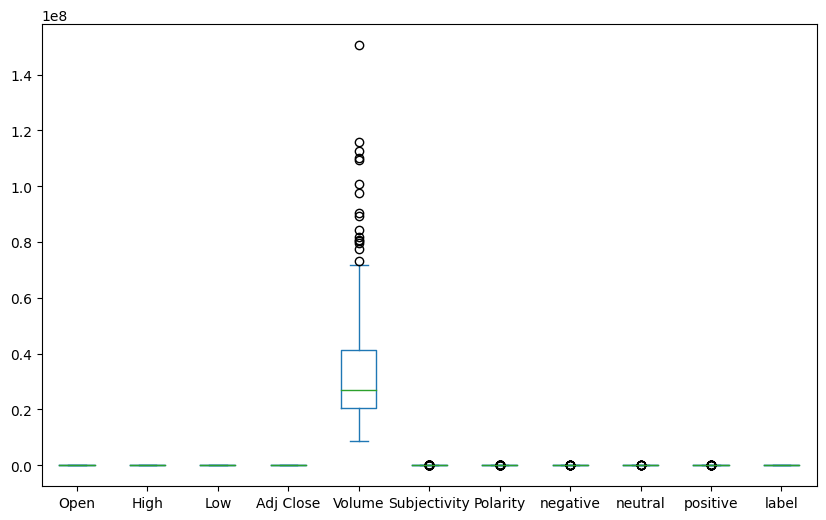

In [115]:
#graficamos las variables numericas para ver su distribucion y outliers
data_final.plot.box(figsize=(10, 6))

Se puede observar que el volumen hay valores muy altos como vamos, esto se debe a que las negocioaciones en el mercado de acciones no tienen un tendencia definida

### 2.6.2 Análisis bivariable

  •    Correlaciones entre las variables predictoras deben ser menores a 0.8
  
  •    Correlaciones con la variable objetivo debe ser mayor a 0.07

<Axes: >

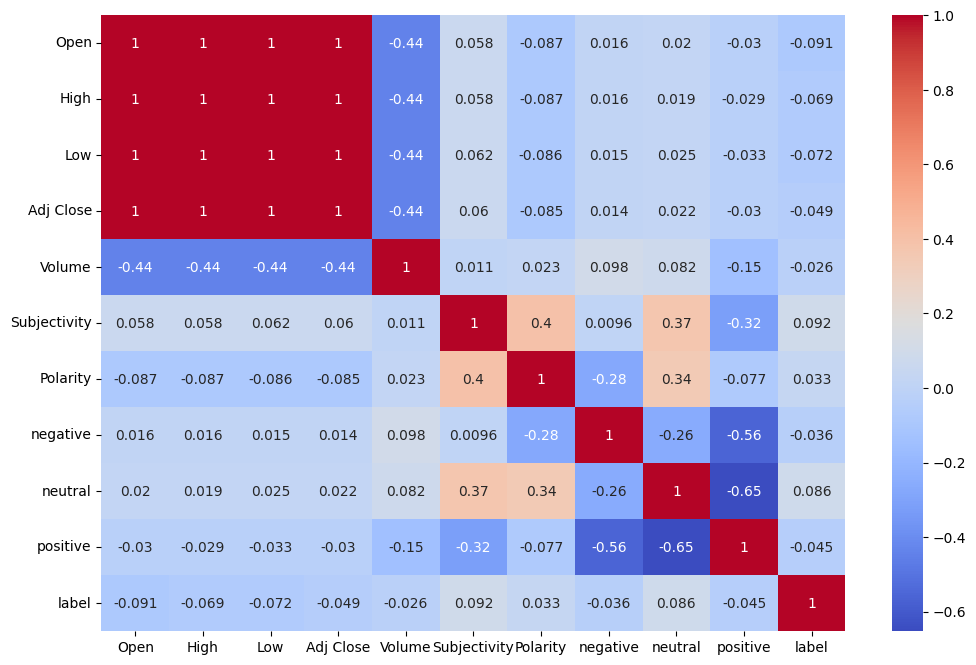

In [100]:
# correlacion variables numericas
corr = data_final.corr()

# plot the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        cmap='coolwarm')

In [132]:
data_copy = data_final.copy()

In [143]:
# Crear una matriz de correlación
corr_matrix = data_final.corr()

# Definir umbral para correlaciones entre variables predictoras y variable objetivo
threshold_pred = 0.035
threshold_corr = 0.8

# Encontrar columnas con correlaciones entre variables predictoras mayores a 0.7
high_corr_predictors = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold_corr:
            colname = corr_matrix.columns[i]
            high_corr_predictors.add(colname)

# Eliminar la columna 'CHURN' de la lista high_corr_predictors si está presente
if 'label' in high_corr_predictors:
    high_corr_predictors.remove('label')

# Encontrar columnas con correlaciones con la variable objetivo mayores a 0.1
high_corr_target = set()
for col in corr_matrix.columns:
    if abs(corr_matrix.loc['label', col]) < threshold_pred:
        high_corr_target.add(col)

# Eliminar la columna 'CHURN' de la lista high_corr_predictors si está presente
if 'label' in high_corr_target:
    high_corr_target.remove('label')

# Combinar columnas a eliminar (unión de las dos listas)
columns_to_drop = high_corr_predictors.union(high_corr_target)

# Eliminar las columnas seleccionadas del DataFrame
data_copy_filtered = data_copy.drop(columns=columns_to_drop)

data_copy_filtered.head()

Open  Subjectivity  negative   neutral  positive  label
Date                                                                 
2021-10-01  341.61      0.473276  0.000000  0.318077  0.681923      1
2021-10-04  335.53      0.447803  0.336256  0.269949  0.393795      0
2021-10-05  328.58      0.388048  0.146736  0.392092  0.461172      1
2021-10-06  329.74      0.430650  0.404048  0.406286  0.189666      1
2021-10-07  337.00      0.376437  0.066893  0.415530  0.517577      0

### **Conclusiones Análisis Bivariable**

- Para realizar el modelo nos quedamos con las variables Open, Subjectivity, negative, neutral, positive y label

### 2.7 Balanceo de datos

In [254]:
data_copy_filtered['label'].value_counts() / len(data_copy_filtered['label']) * 100

label
1    51.076321
0    48.923679
Name: count, dtype: float64

In [144]:
#Copiamos el dataset filtrado
data_model = data_copy_filtered.copy()

In [145]:
#Verificamos tipos de datos y nulos
data_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 511 entries, 2021-10-01 to 2023-11-17
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          511 non-null    float64
 1   Subjectivity  511 non-null    float64
 2   negative      511 non-null    float64
 3   neutral       511 non-null    float64
 4   positive      511 non-null    float64
 5   label         511 non-null    int32  
dtypes: float64(5), int32(1)
memory usage: 25.9 KB


In [146]:
#Balanceo de datos
from imblearn.over_sampling import SMOTE

In [147]:
# Separar las variables predictoras (X) y la variable objetivo (y)
X = data_model.drop('label', axis=1)
y = data_model['label']

# Instanciar el objeto SMOTE ya que todas las variables predictoras son numéricas
smote = SMOTE(random_state=42)

# Aplicar SMOTE para balancear los datos
X_resampled, y_resampled = smote.fit_resample(X, y)

# Crear un nuevo DataFrame con los datos balanceados
df_balanceado = pd.DataFrame(X_resampled, columns=X.columns)
df_balanceado['label'] = y_resampled

# Verifica el balance despues de aplicar SMOTE
print(df_balanceado['label'].value_counts())

label
1    261
0    261
Name: count, dtype: int64


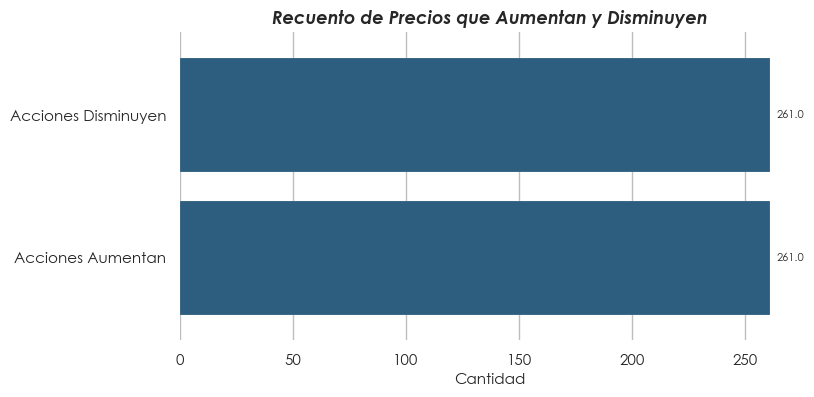

In [155]:
# Son graficados las polizas vigentes y no vigentes
recuento = df_balanceado['label'].value_counts()
recuento.index = ["Acciones Aumentan" if etiqueta == 0 else "Acciones Disminuyen" for etiqueta in recuento.index]
# Configurar el estilo de Seaborn
font = {'family': 'Century Gothic','size':8}
plt.rc('font', **font)
fig, ax = plt.subplots(figsize=(8, 4))
fig.subplots_adjust(hspace=0.5)
sns.set(font=font, context="notebook", style="darkgrid")
# Crear el gráfico horizontal con Seaborn
barplot = sns.barplot(x=recuento.values, y=recuento.index, edgecolor='white', color='#21618C', linewidth=0.1)

ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Añadir etiquetas y título
sns.despine(left=True, bottom=True)
ax.xaxis.grid(True, color='#bdbdbd')
ax.set_xlabel("Cantidad", fontsize=11)
ax.set_title("Recuento de Precios que Aumentan y Disminuyen", fontsize=13, fontweight='bold',style="italic")
ax.margins(y=0.1)

for p in barplot.patches:
    ax.annotate(f'{p.get_width()}',
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontsize=8, fontfamily='Century Gothic')


plt.show()

## **Ya se tiene el DataFrame listo para pasar al modelado**

In [156]:
df_balanceado

Open  Subjectivity  negative   neutral  positive  label
0    341.610000      0.473276  0.000000  0.318077  0.681923      1
1    335.530000      0.447803  0.336256  0.269949  0.393795      0
2    328.580000      0.388048  0.146736  0.392092  0.461172      1
3    329.740000      0.430650  0.404048  0.406286  0.189666      1
4    337.000000      0.376437  0.066893  0.415530  0.517577      0
..          ...           ...       ...       ...       ...    ...
517  117.193691      0.411918  0.000000  0.498333  0.501667      0
518  365.631736      0.411171  0.152160  0.449702  0.398138      0
519  162.351846      0.399705  0.137155  0.267236  0.595609      0
520  338.929435      0.473161  0.069754  0.240731  0.689515      0
521  330.586605      0.499270  0.180821  0.320893  0.498286      0

[522 rows x 6 columns]

### **Se guarda el DataFrame Final para el modelamiento**

In [159]:
df_balanceado.to_csv("../data/processed/data_processed_modeling.csv", sep=',', encoding='utf-8', header=True, index=False)